In [3]:
%matplotlib inline

In [4]:
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import auc

In [5]:
import analyse

In [6]:
_MAP_SAMPLE_TO_POOL = {
    "A": ["A", "B"],
    "B": ["B"],
    "C": ["A"],
    "D": []
}

In [7]:
_PEP_THRESH_LIST = [
    0,
    0.000001, 0.000005,
    0.00001, 0.00005,
    0.0001, 0.0005,
    0.001, 0.005,
    0.01, 0.05,
    0.1
]

# Read in data

In [8]:
filenames = [
    f for f in os.listdir(".")
    if f.endswith(".json")
]

In [9]:
data = {}
for fn in filenames:
    sample, rep = fn[0], int(fn[1])
    engine = fn.split("_")[1]
    version = "Percolator-Repl-All" if "_v1_" in fn else "Percolator-Repl-Top"
    
    key = (sample, rep, engine, version)
    with open(fn) as f:
        data[key] = json.load(f)

In [10]:
dirname = "/Users/sophiamersmann/Dropbox/student/imperial_college_london/GSoC/datasets/iPRG2016/analysis"
filenames = [
    os.path.join(dirname, f) for f in os.listdir(dirname)
    if f.endswith(".json") and
    ("IDPEP" in f or "0.05" in f)
]

In [11]:
for fn in filenames:
    basename = os.path.basename(fn)
    sample, rep = basename[0], int(basename[1])
    engine = basename.split("_")[1]
    method = "Percolator" if "percolator" in basename else "IDPEP"
    
    key = (sample, rep, engine, method)
    with open(fn) as f:
        data[key] = json.load(f)

In [12]:
pools_fn = [
    (pool_key, "../../mixtures/prest_pool_{}.txt".format(pool_key.lower()))
    for pool_key in list("AB")
]
pools_fn

[('A', '../../mixtures/prest_pool_a.txt'),
 ('B', '../../mixtures/prest_pool_b.txt')]

In [13]:
def read_pool(fn):
    with open(fn) as f:
        content = [line.rstrip() for line in f]
    return content

In [14]:
pools = {
    pools_key: read_pool(fn)
    for pools_key, fn in pools_fn
}

# Distributions

## PEPs

In [15]:
def is_target(psm):
    return any(p.startswith("HPRR") for p in psm["proteins"])

In [16]:
def is_decoy(psm):
    return any(p.startswith("random_") for p in psm["proteins"])

In [17]:
def is_correct(psm, sample):
    protein_lists = [
        pools[pool_key]
        for pool_key in _MAP_SAMPLE_TO_POOL[sample]
    ]
    
    present_proteins = [p for ls in protein_lists for p in ls]
    detected_proteins = [p for p in psm["proteins"] if p.startswith("HPRR")]
    
    return len(set(detected_proteins) & set(present_proteins)) > 0

In [18]:
def plot_feature_distributions(feature, versions=["IDPEP", "Percolator", "Percolator-Repl-All", "Percolator-Repl-Top"]):
    for sample in list("ABCD"):
        for rep in [1, 2, 3]:
            fig, axarr = plt.subplots(1, 3, figsize=(20, 5))
            for i, engine in enumerate(["xtandem", "msgf", "comet"]):
                for j, method in enumerate(versions):
                    key = (sample, rep, engine, method)
                    if key in data:
                        d = data[key]
                        target_psms = [
                            psm for psm in d
                            if feature in psm and is_target(psm)
                        ]
                    
                        correct_peps = [
                            psm[feature] for psm in target_psms
                            if is_correct(psm, sample)
                        ]
                        incorrect_peps = [
                            psm[feature] for psm in target_psms
                            if not is_correct(psm, sample)
                        ]
            
                        axarr[i].hist(correct_peps, bins=50, color="C{}".format(j), label="{} (correct)".format(method), alpha=0.3)
                        axarr[i].hist(incorrect_peps, bins=50, color="C{}".format(j), label="{} (incorrect)".format(method), histtype="step")
                        axarr[i].set_xlabel(feature)
                        axarr[i].set_ylabel("Count")
                        axarr[i].legend()
                        axarr[i].set_title(engine)
            plt.suptitle("Sample {}{}".format(sample, rep));
            plt.show(fig)
            plt.close(fig)

In [19]:
def plot_feature_distributions_decoys(feature, methods=["Percolator", "Percolator-Repl-All", "Percolator-Repl-Top"]):
    for sample in list("ABCD"):
        for rep in [1, 2, 3]:
            fig, axarr = plt.subplots(1, 3, figsize=(20, 5))
            for i, engine in enumerate(["xtandem", "msgf", "comet"]):
                for j, method in enumerate(methods):
                    key = (sample, rep, engine, method)
                    if key in data:
                        d = data[key]
                        
                        decoy_peps = [
                            psm[feature] for psm in d
                            if feature in psm and is_decoy(psm)
                        ]
                        
                        axarr[i].hist(decoy_peps, bins=50, alpha=0.3, color="C{}".format(j), label="{} (decoys)".format(method))
                        axarr[i].set_xlabel(feature)
                        axarr[i].set_ylabel("Count")
                        axarr[i].legend()
                        axarr[i].set_title(engine)
            plt.suptitle("Sample {}{}".format(sample, rep));
            plt.show(fig)
            plt.close(fig)

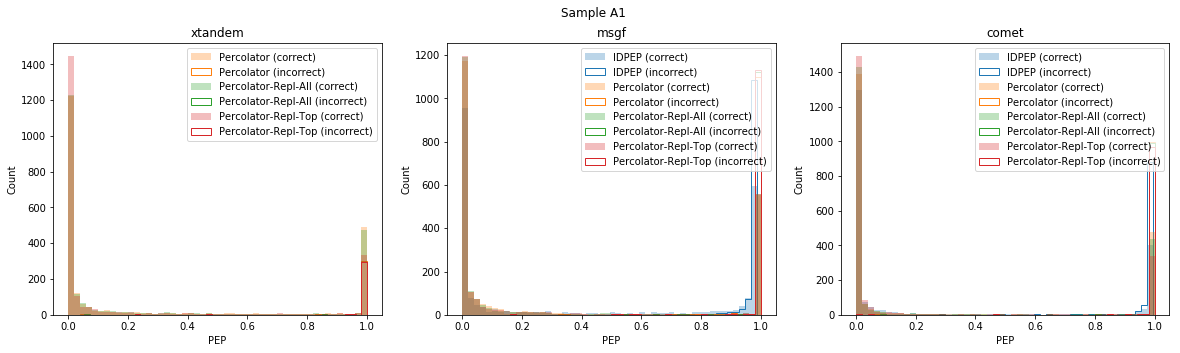

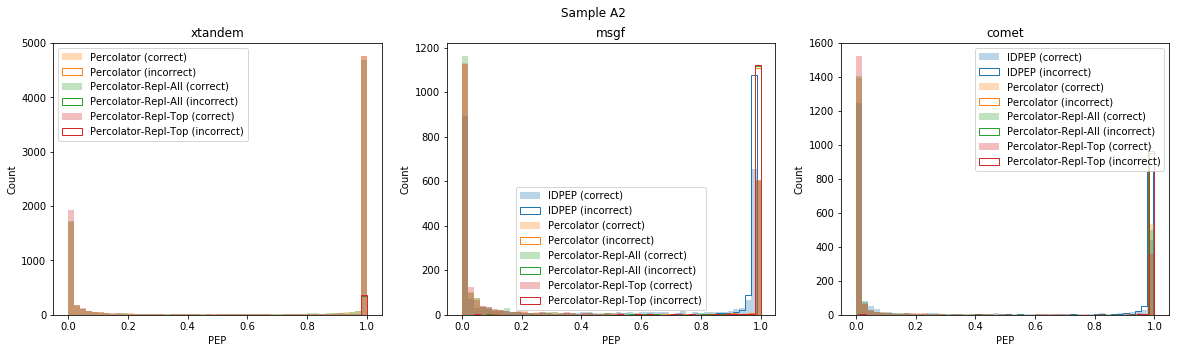

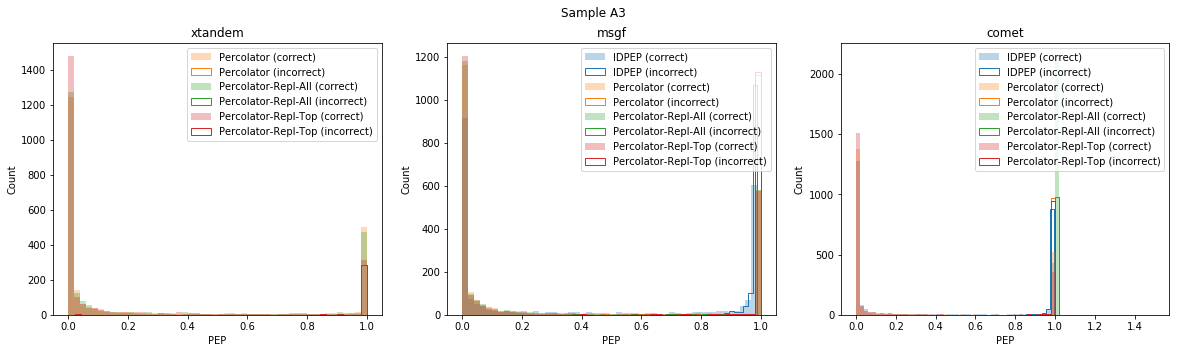

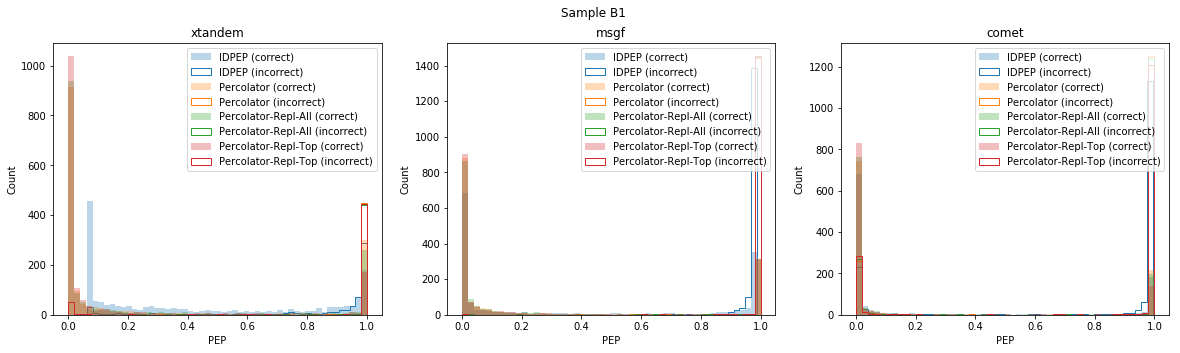

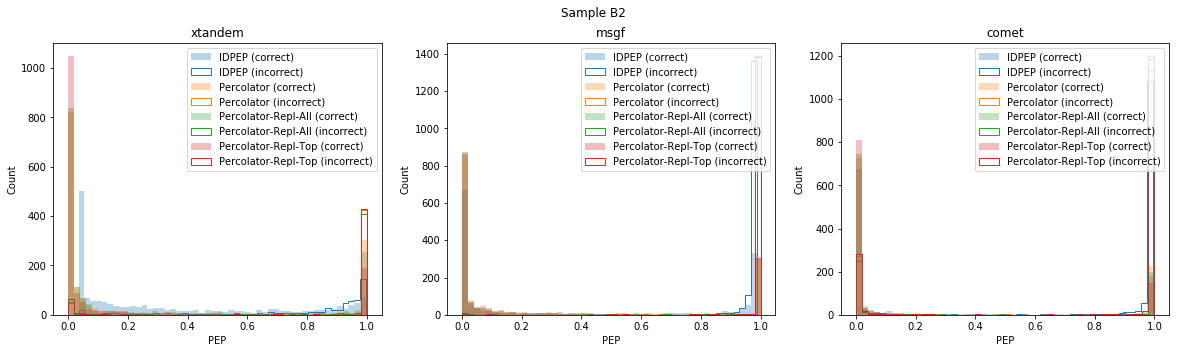

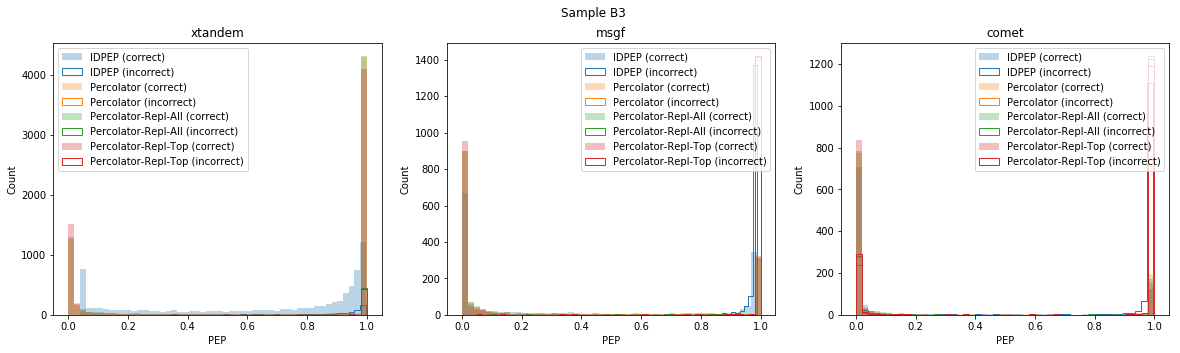

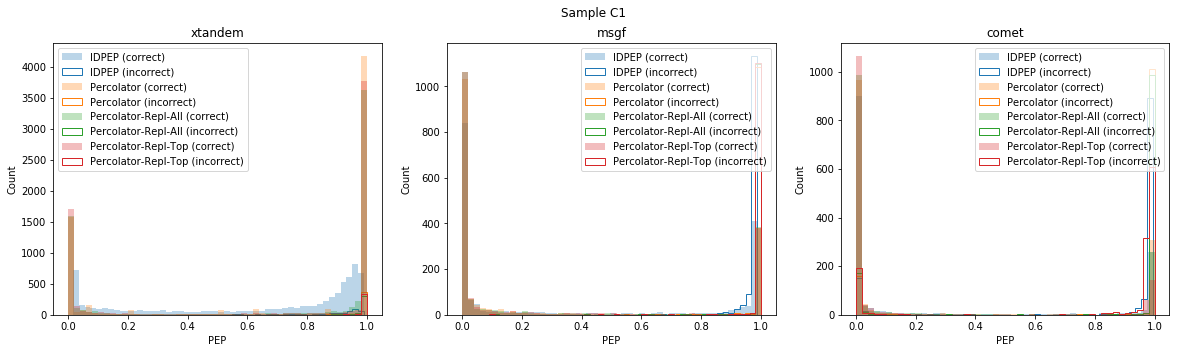

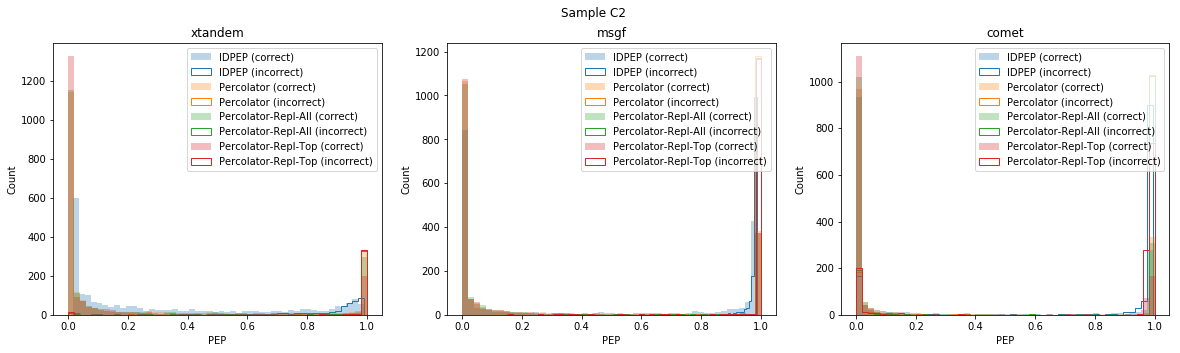

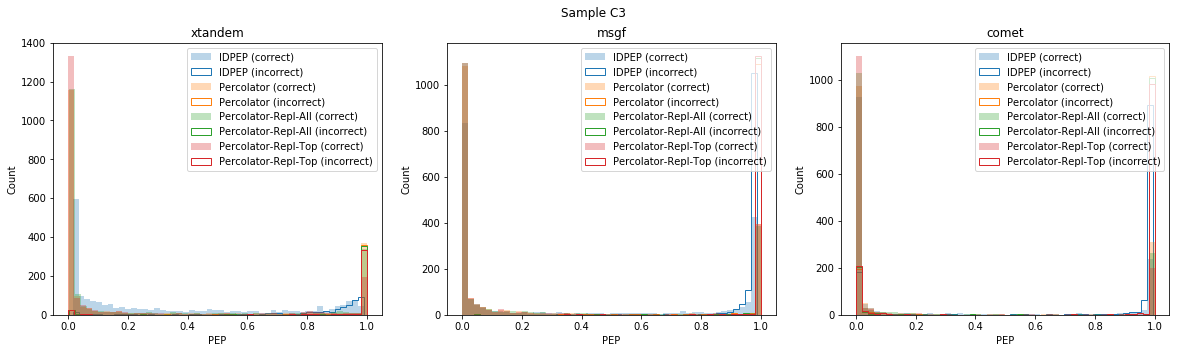

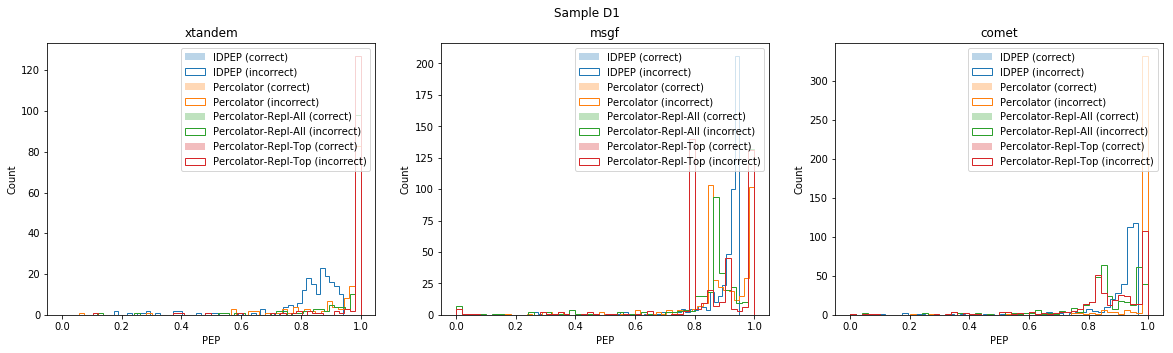

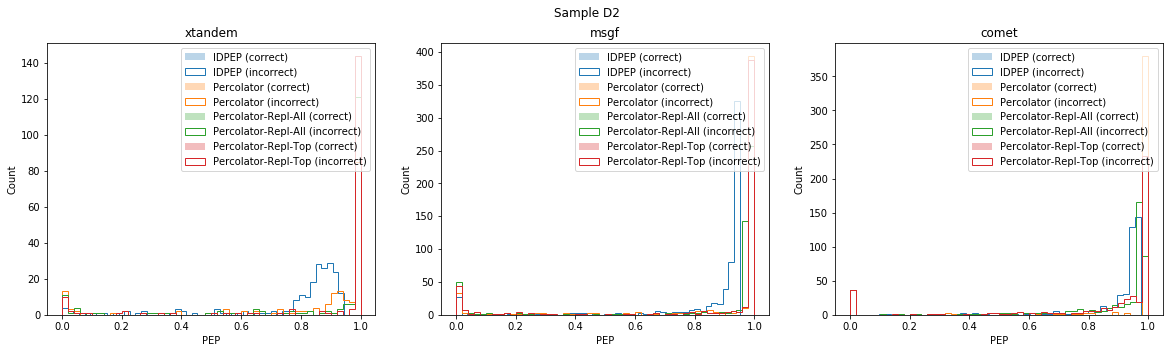

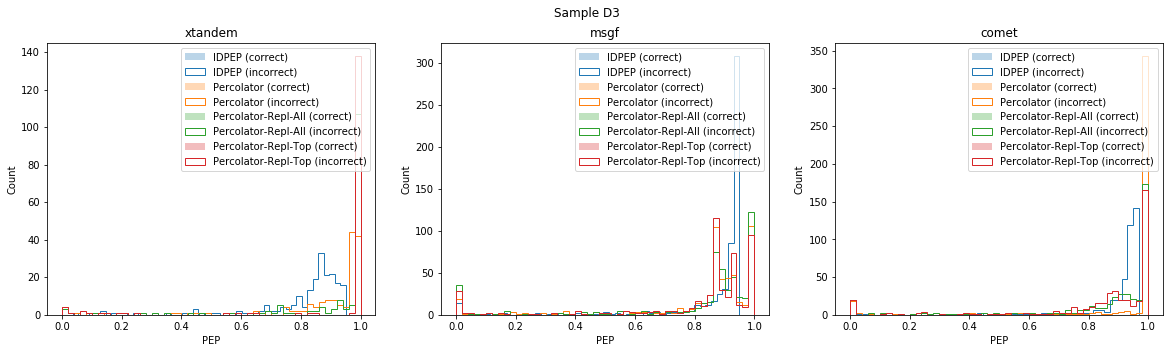

In [112]:
plot_feature_distributions("PEP")

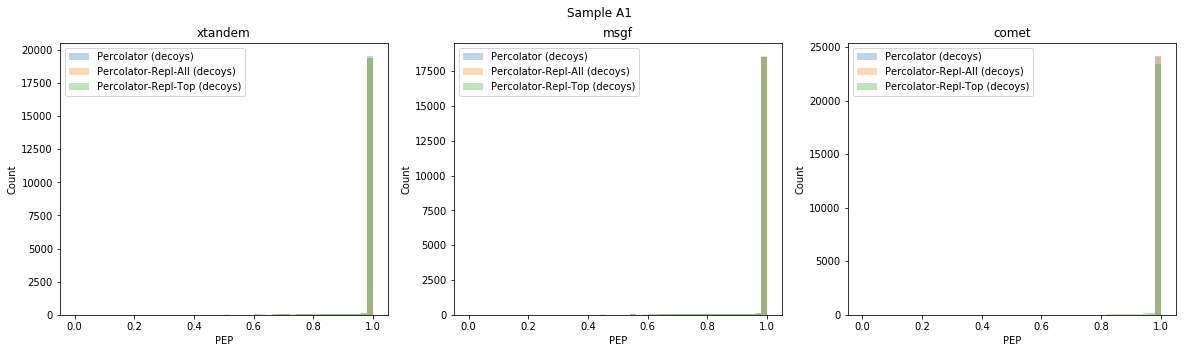

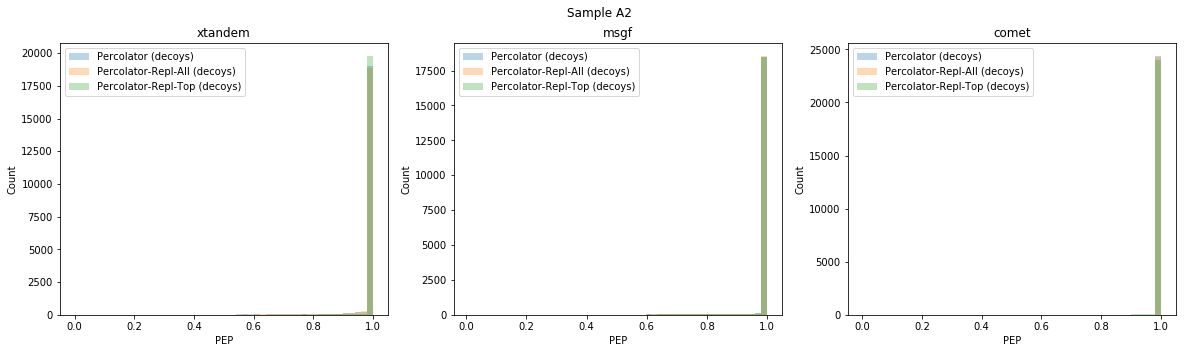

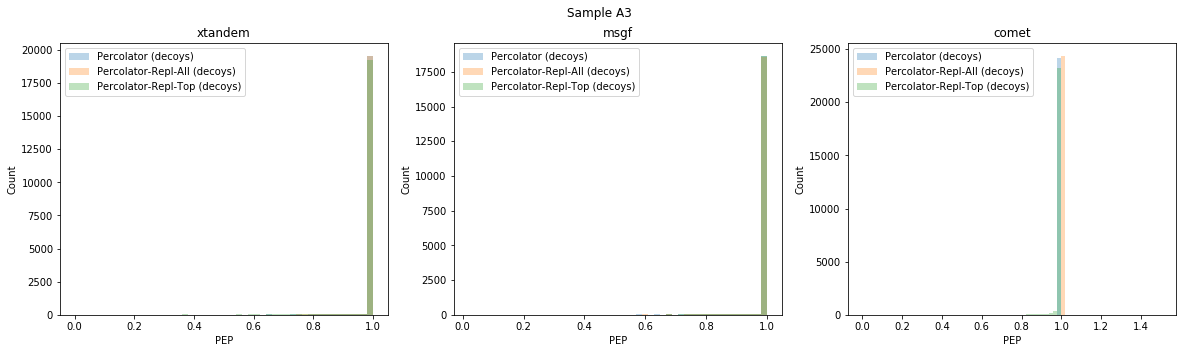

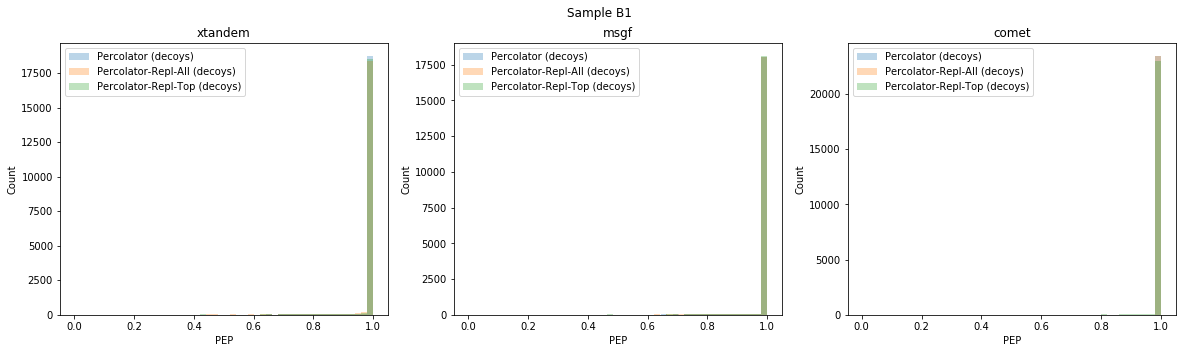

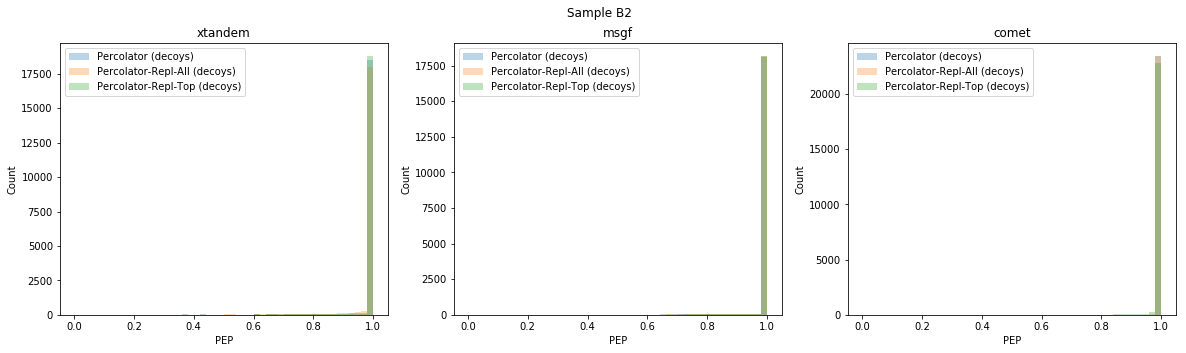

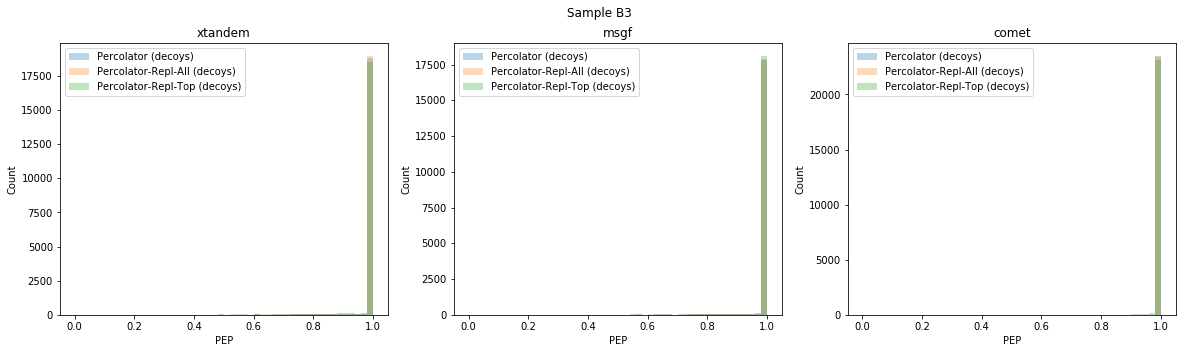

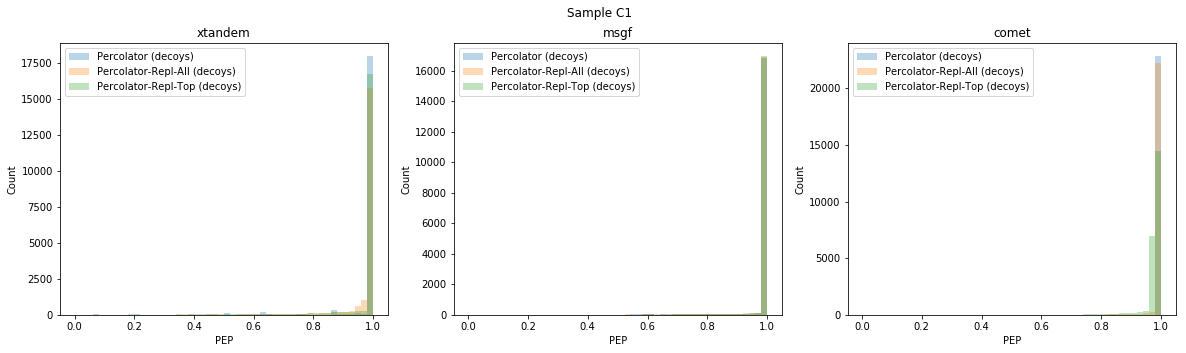

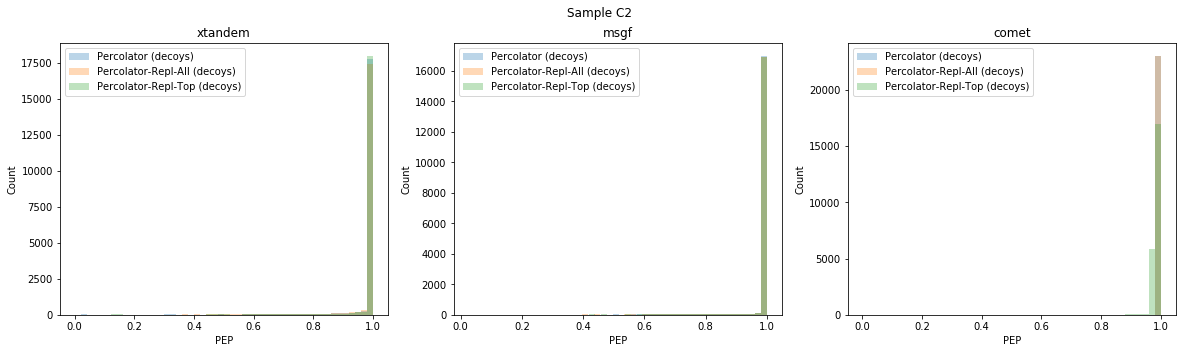

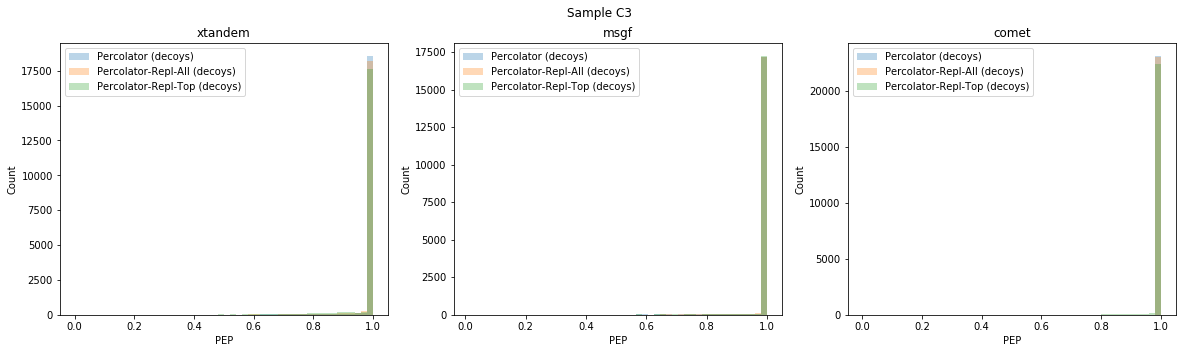

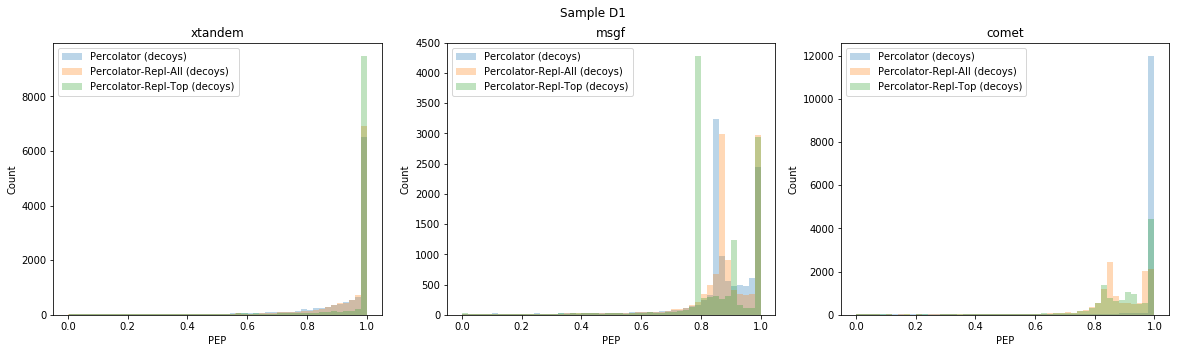

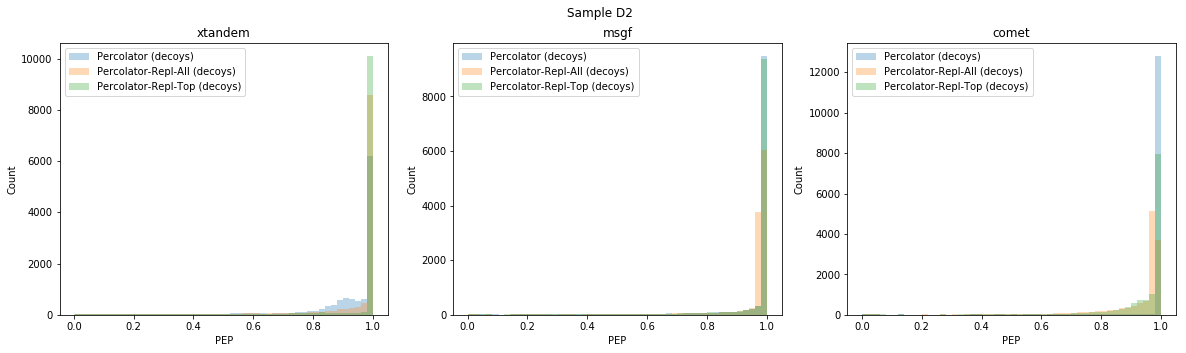

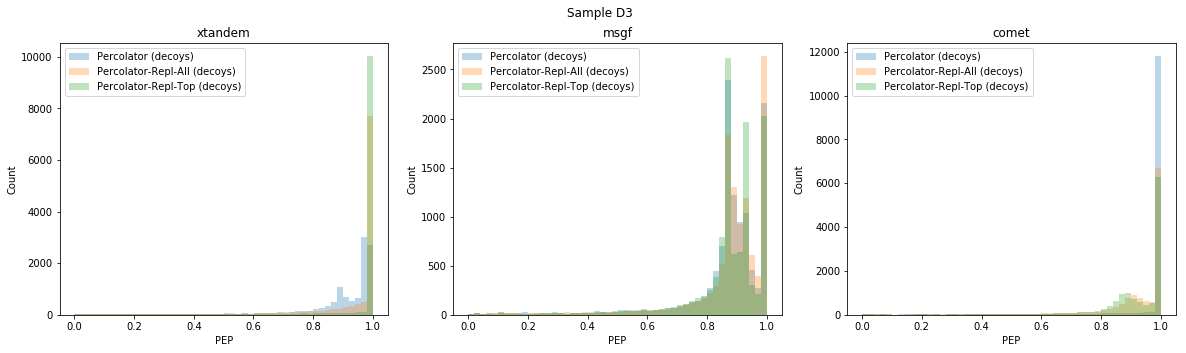

In [113]:
plot_feature_distributions_decoys("PEP")

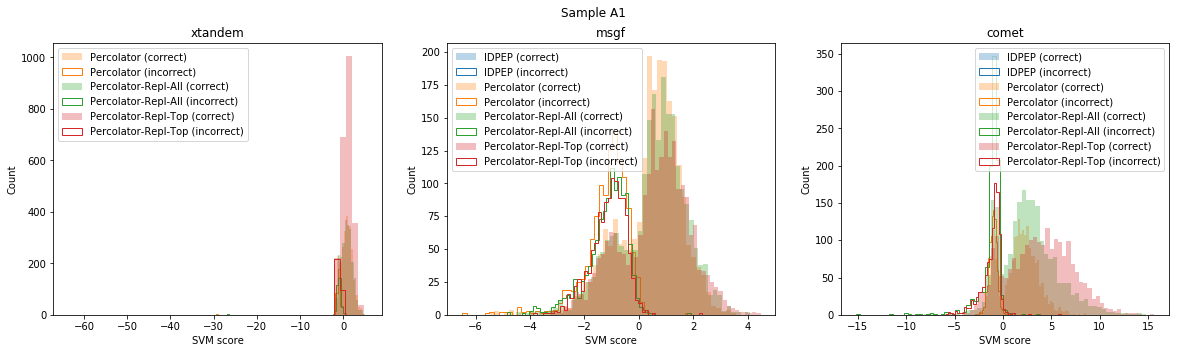

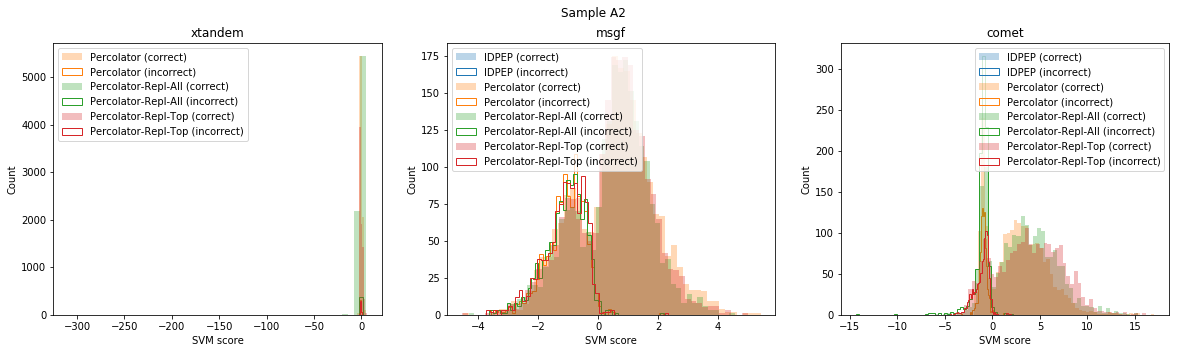

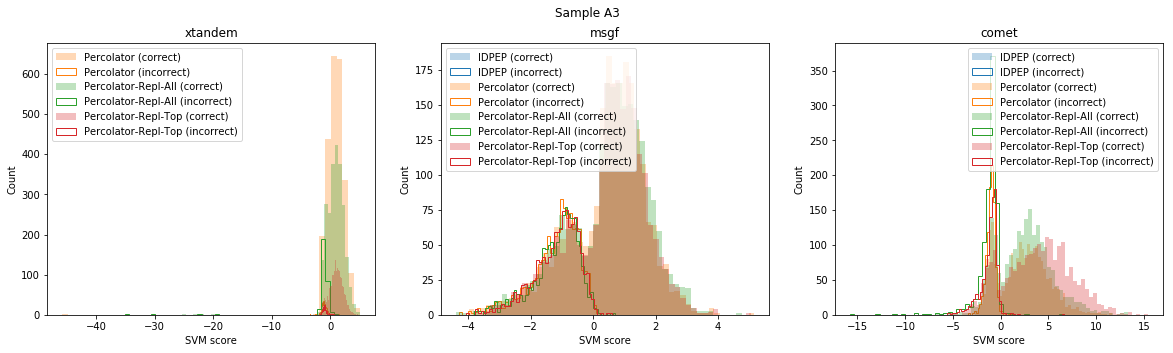

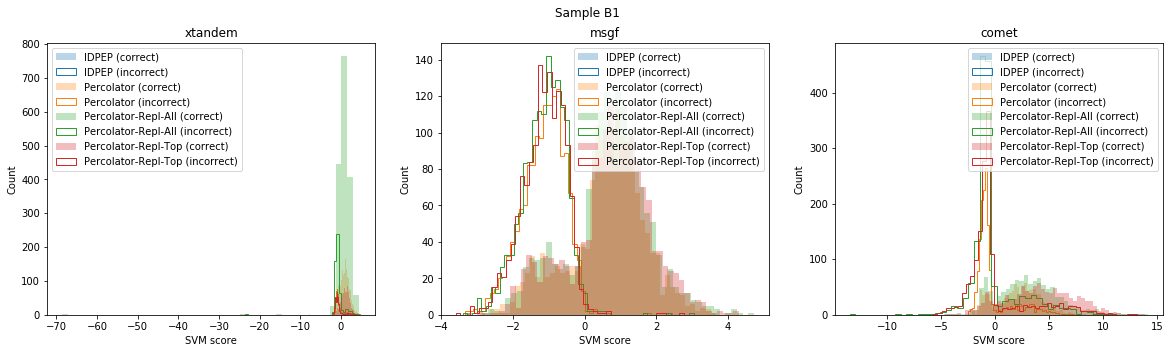

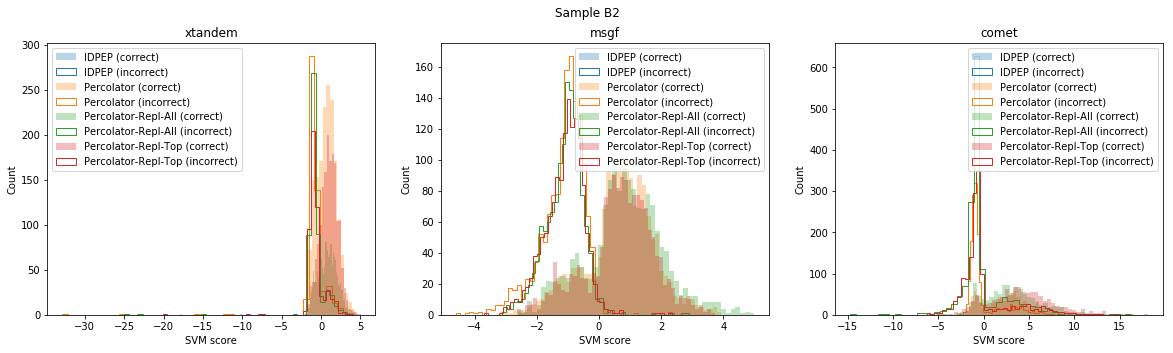

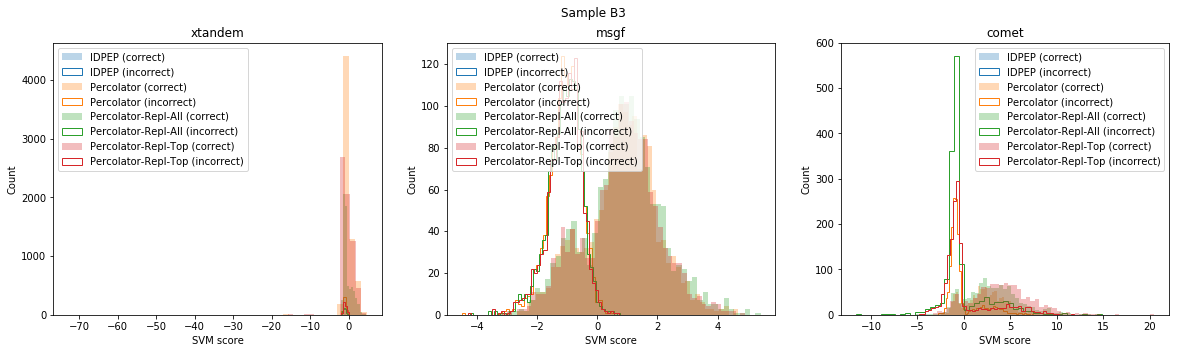

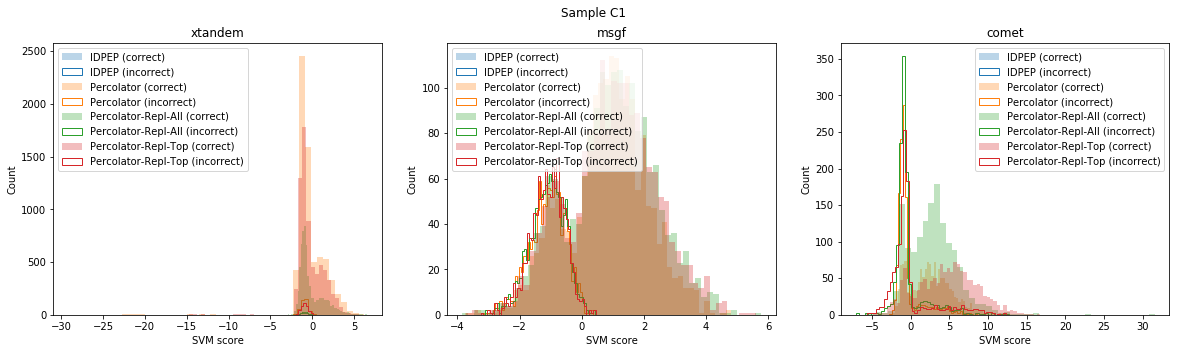

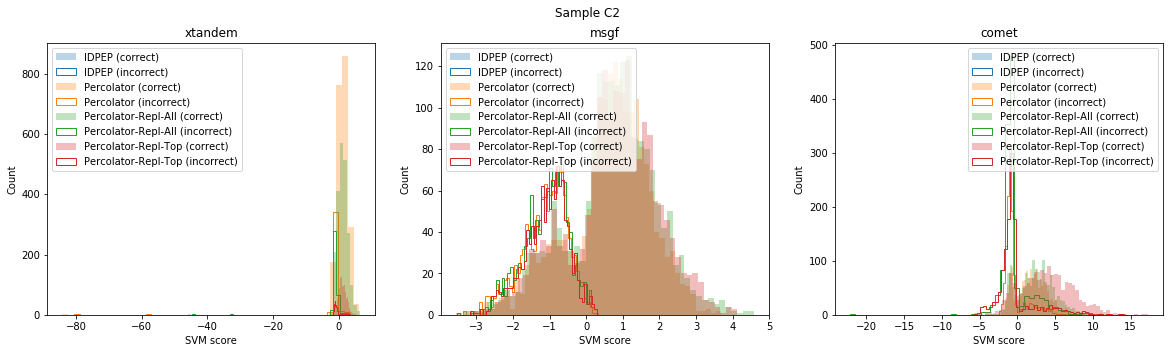

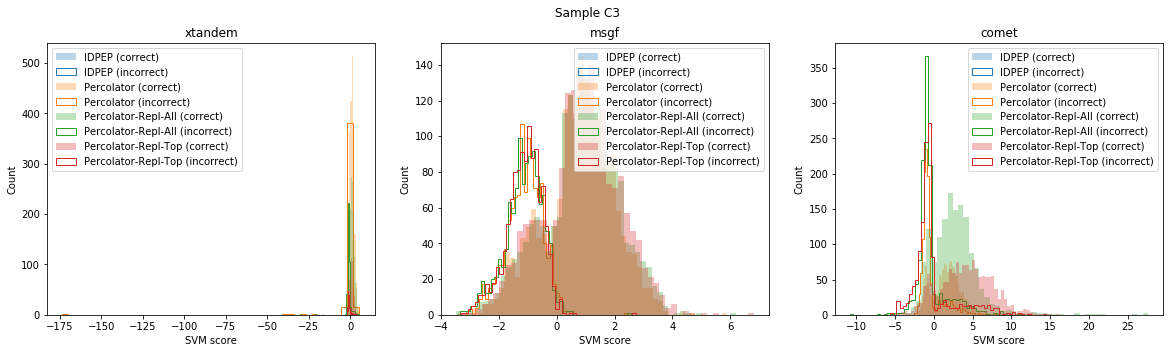

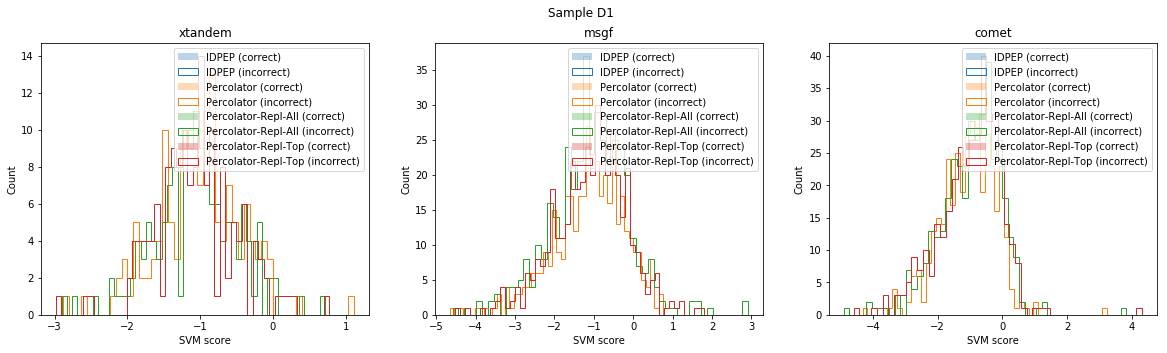

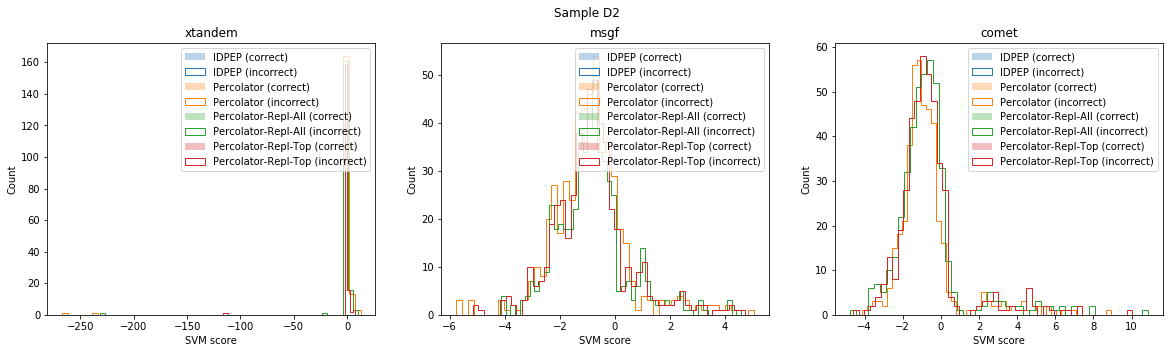

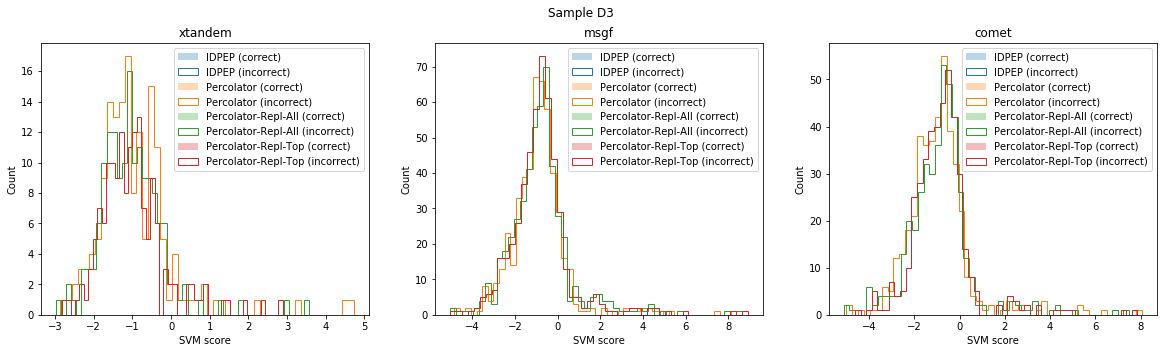

In [114]:
plot_feature_distributions("SVM score")

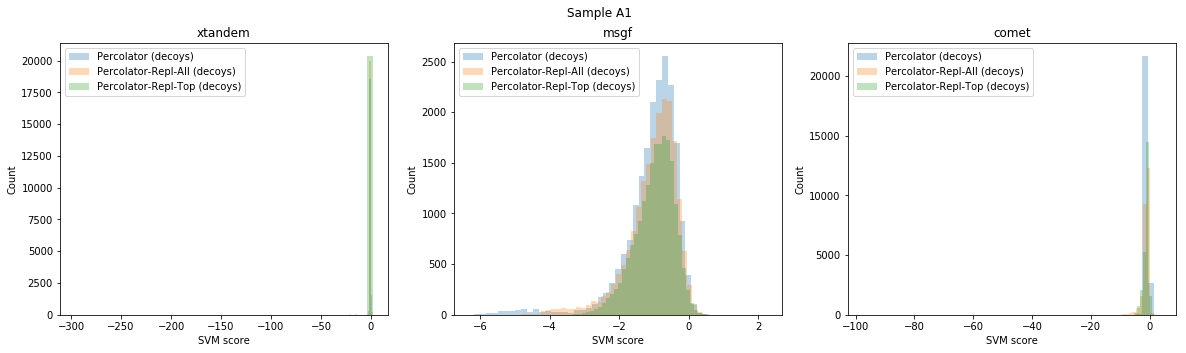

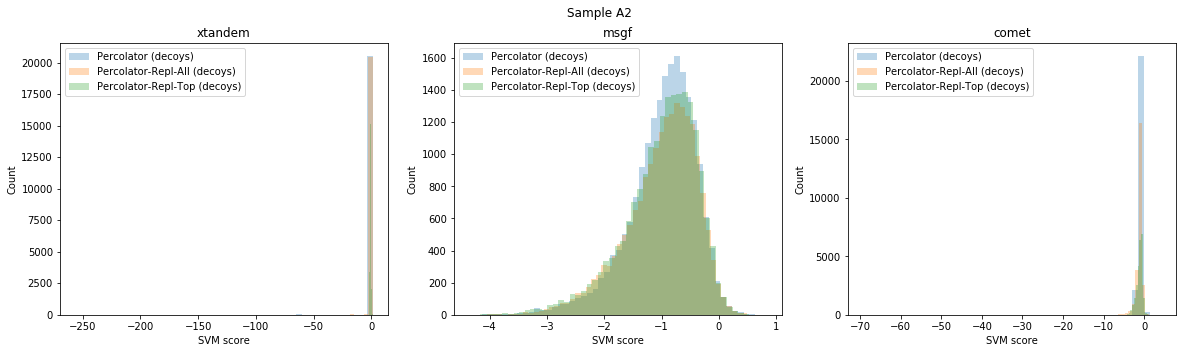

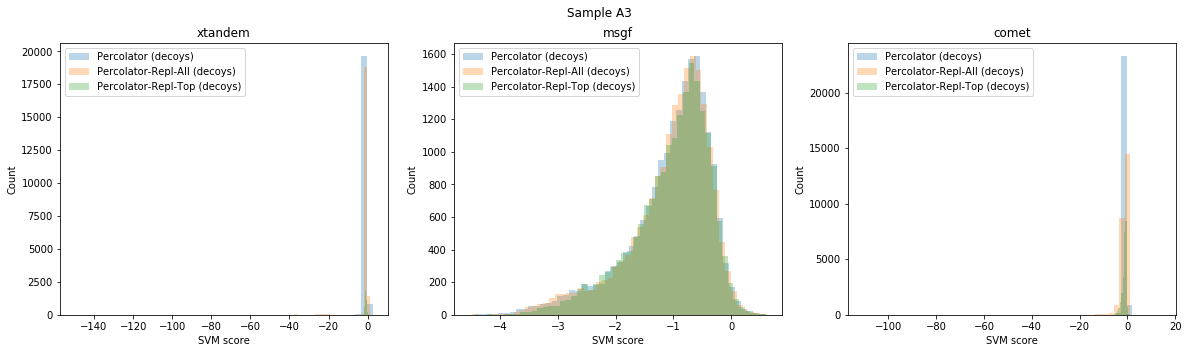

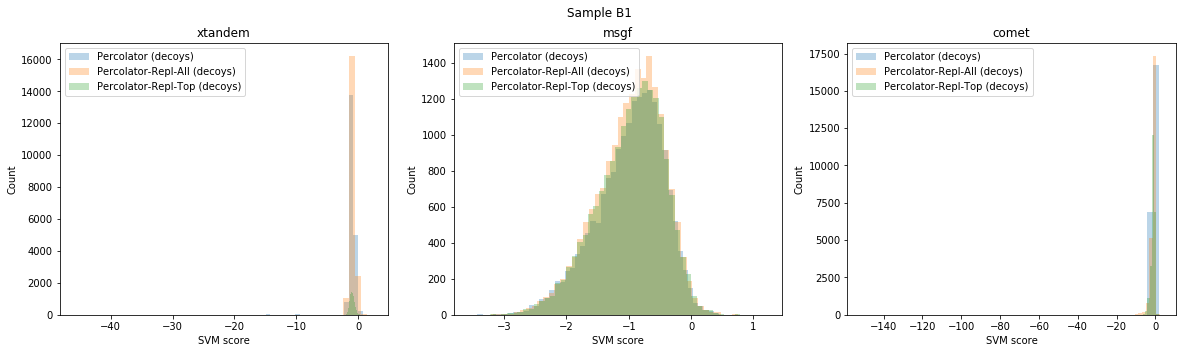

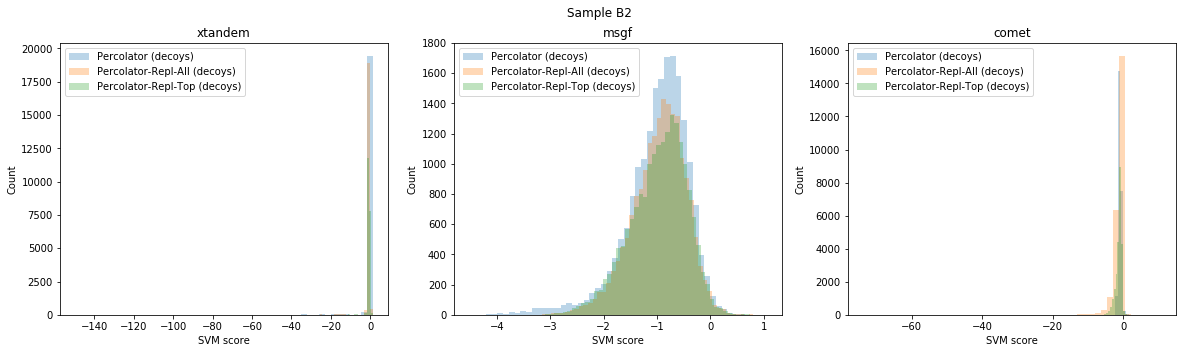

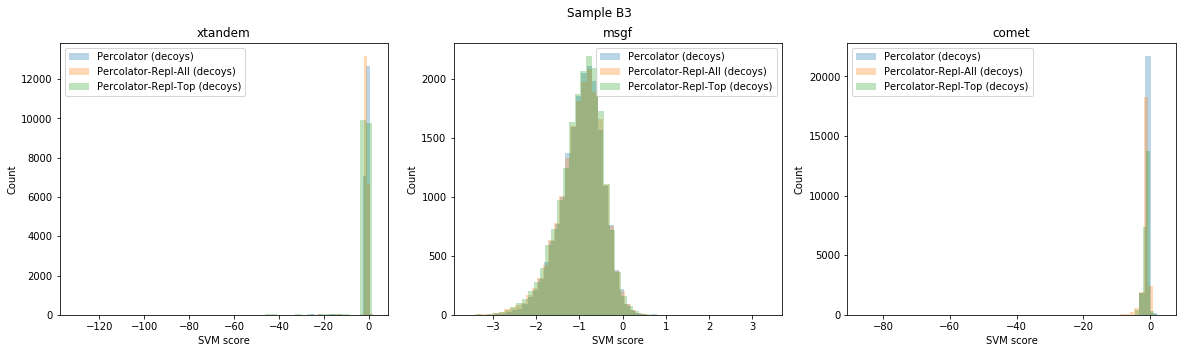

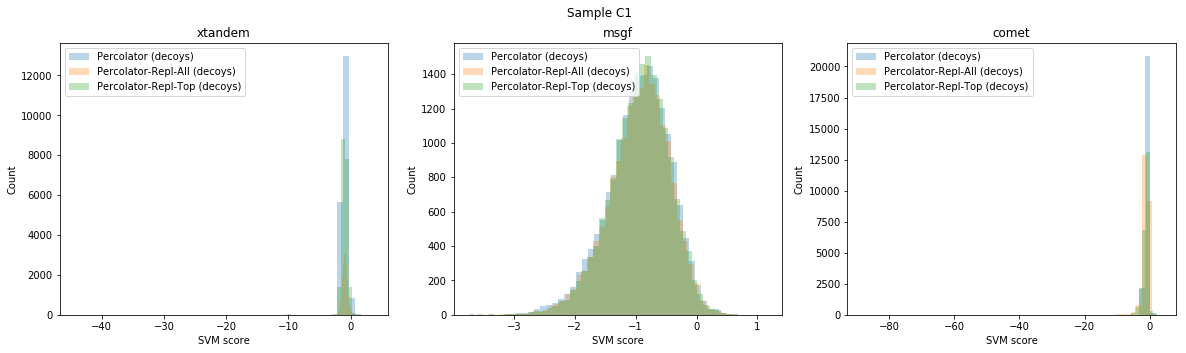

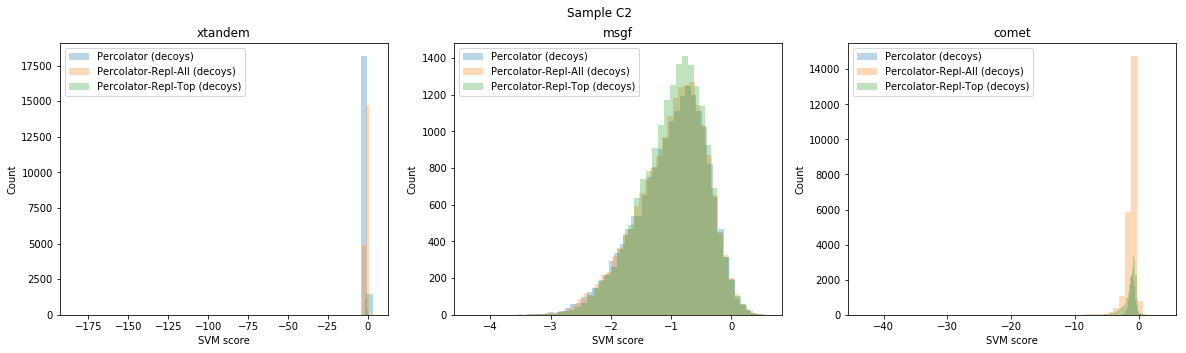

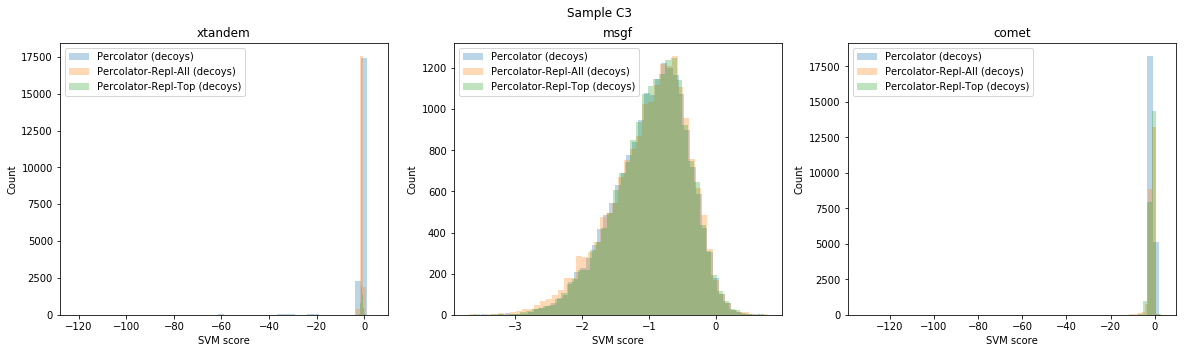

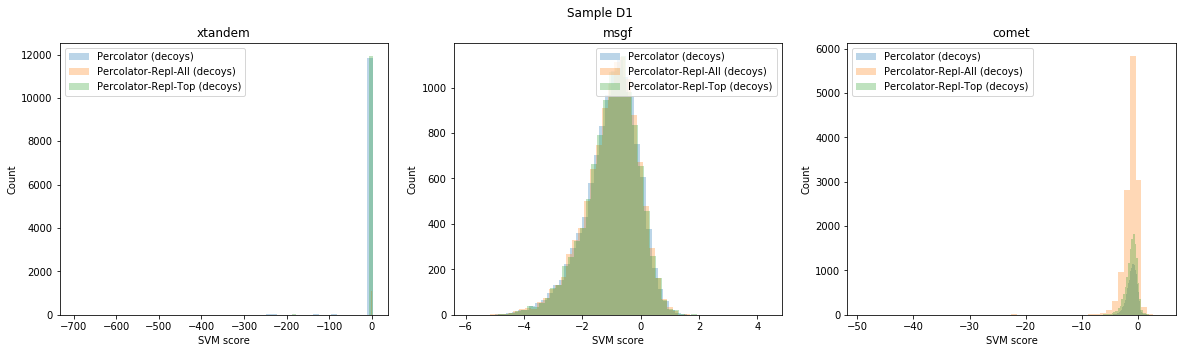

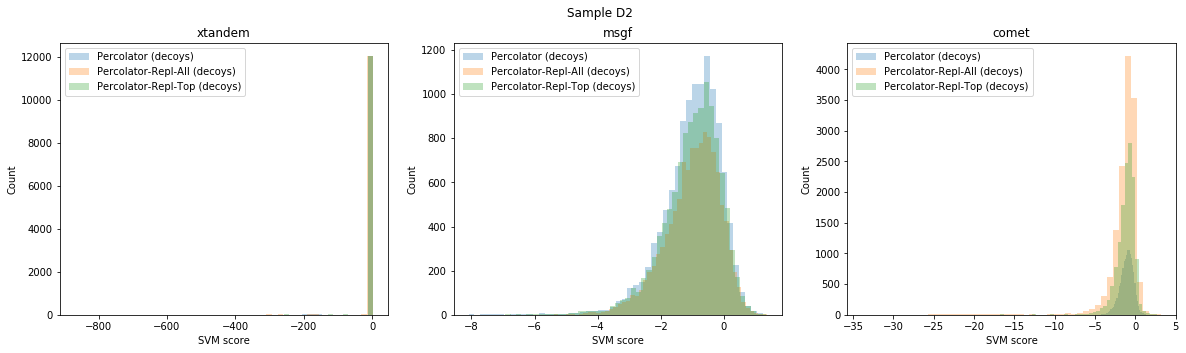

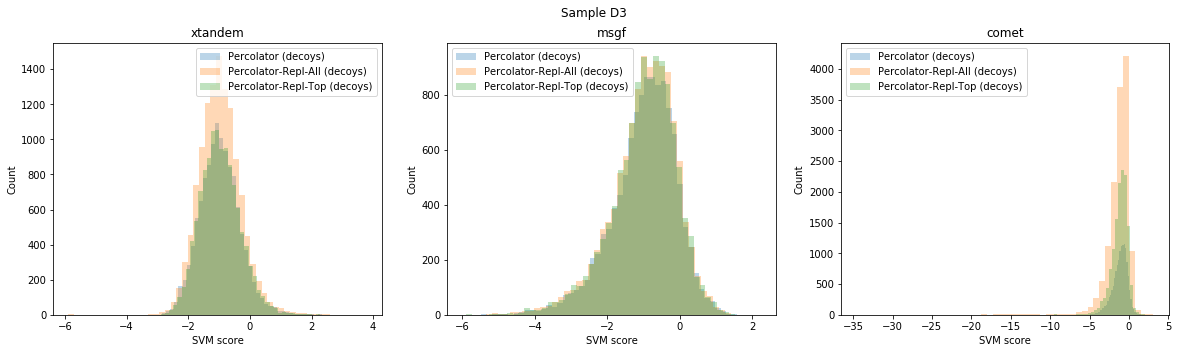

In [115]:
plot_feature_distributions_decoys("SVM score")

# Correct Identifications

In [20]:
def get_pool_proteins(sample):
    protein_lists = [
        pools[pool_key]
        for pool_key in _MAP_SAMPLE_TO_POOL[sample]
    ]
    
    return [p for ls in protein_lists for p in ls]

In [31]:
def plot_correct_identifications(absolute=True):
    for sample in list("ABC"):
        present_proteins = get_pool_proteins(sample)
        n_present_proteins = len(present_proteins)
        for rep in [1, 2, 3]:
            fig, axarr = plt.subplots(1, 3, figsize=(20, 5))
            for i, engine in enumerate(["xtandem", "msgf", "comet"]):
                for j, method in enumerate(["IDPEP", "Percolator", "Percolator-Repl-All", "Percolator-Repl-Top"]):
                    key = (sample, rep, engine, method)
                    if key in data:
                        d = data[key]
                        target_psms = [
                            psm for psm in d
                            if "PEP" in psm and is_target(psm)
                        ]
                        
                        n_correct, n_unique = [], []
                        for pep in _PEP_THRESH_LIST:
                            correct_psms = [
                                psm for psm in target_psms
                                if is_correct(psm, sample) and
                                psm["PEP"] < pep
                            ]
                            
                            correct_proteins = []
                            for psm in correct_psms:
                                psm_correct_proteins = list(filter(
                                    lambda p: p.startswith("HPRR") and p in present_proteins,
                                    psm["proteins"]
                                ))      
                                correct_proteins.extend(psm_correct_proteins)
                                                            
                            n_correct.append(len(correct_proteins))
                            n_unique.append(len(set(correct_proteins)))
                        
                        if not absolute:
                            n_unique = list(map(
                                lambda n: n / n_present_proteins,
                                n_unique
                            ))
            
                        if absolute:
                            axarr[i].plot(_PEP_THRESH_LIST, n_correct, color="C{}".format(j), label="{}".format(method))
                        axarr[i].plot(_PEP_THRESH_LIST, n_unique, color="C{}".format(j), label="{} (unique)".format(method), ls="--")
                        axarr[i].set_xlabel("PEP")
                        axarr[i].set_ylabel("Number of correct identifications")
                        axarr[i].legend()
                        axarr[i].set_title(engine)
                        
                        if not absolute:
                            axarr[i].set_ylim(0, 1)
            plt.suptitle("Sample {}{}".format(sample, rep));
            plt.show(fig)
            plt.close(fig)

## Number of correct identifications

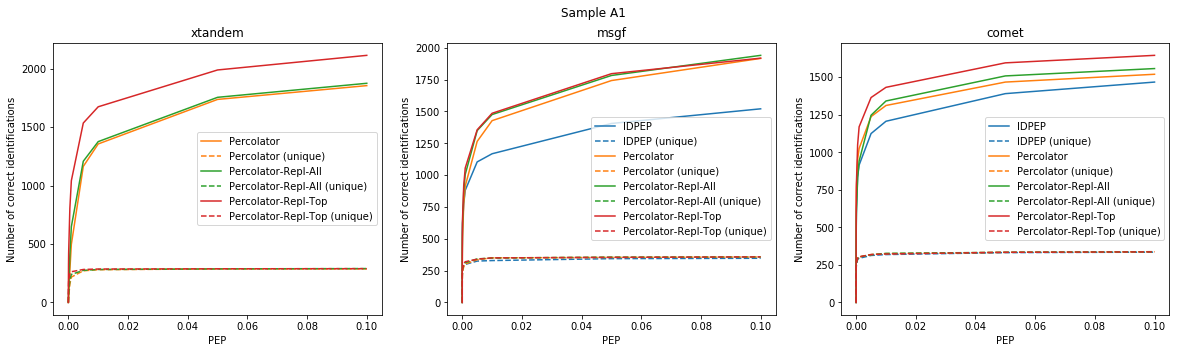

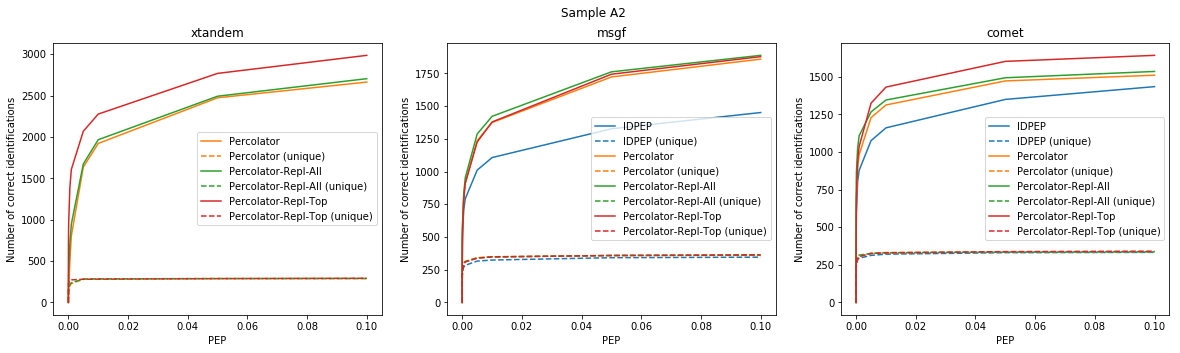

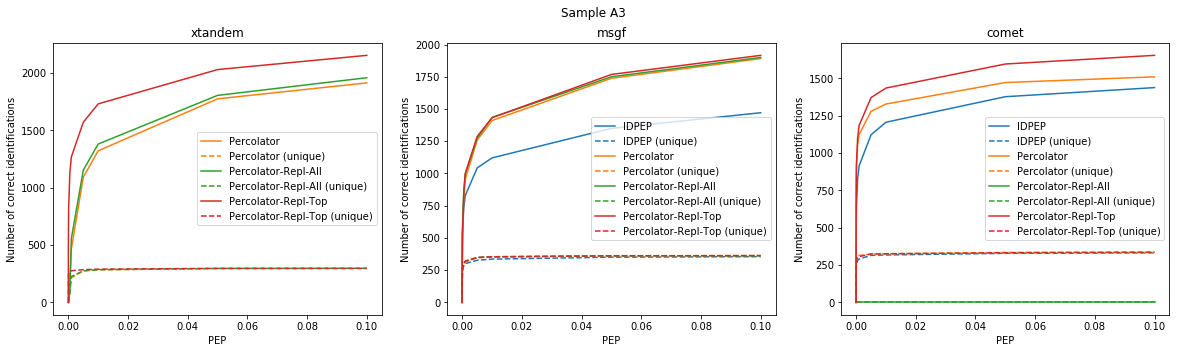

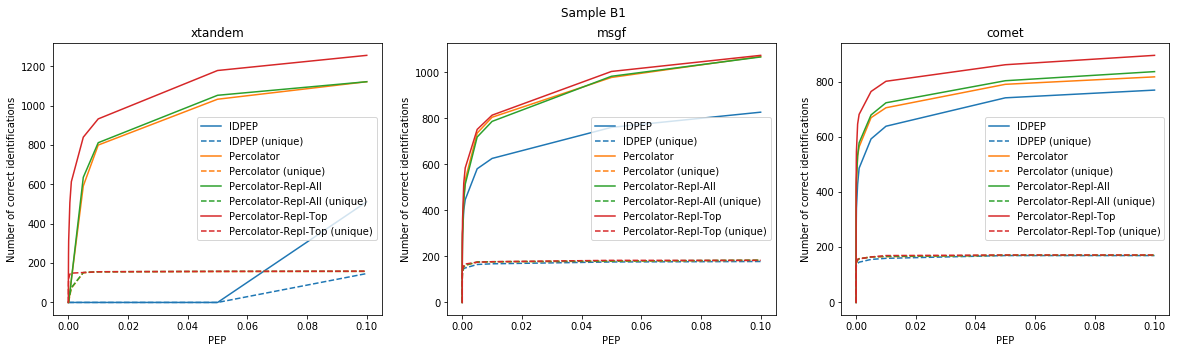

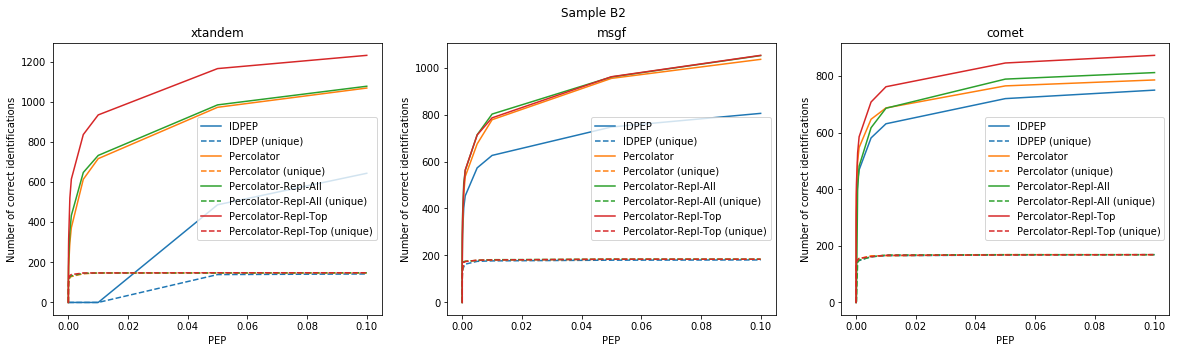

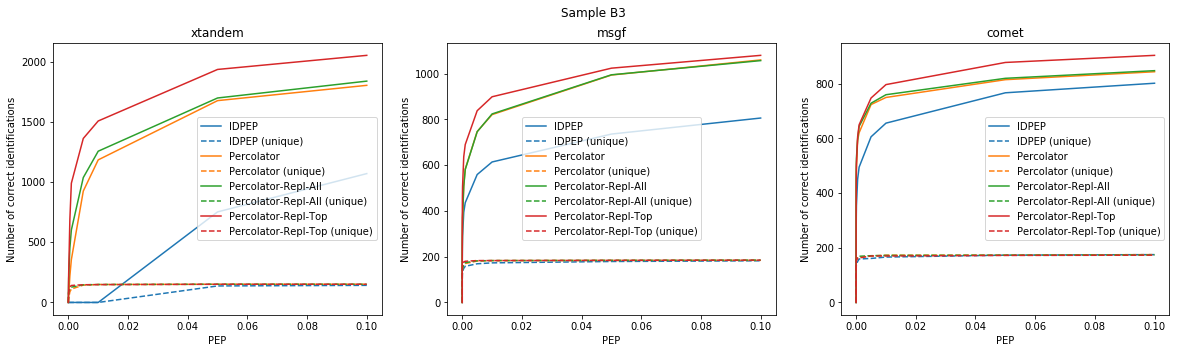

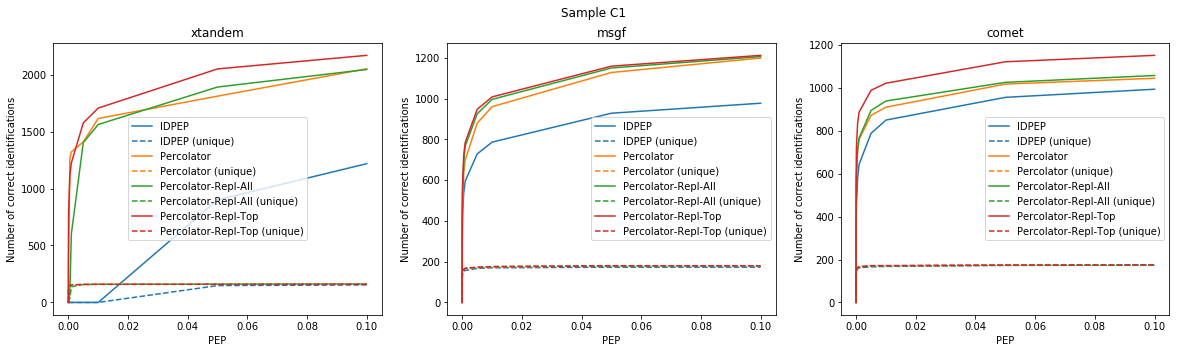

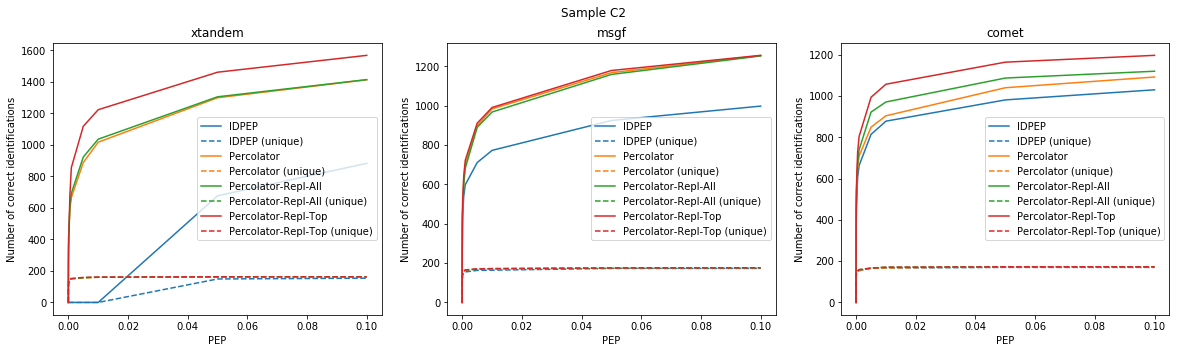

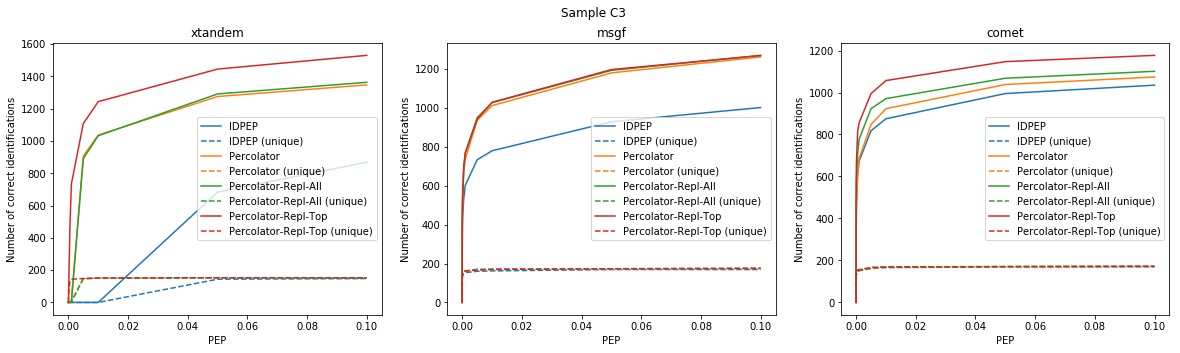

In [32]:
plot_correct_identifications()

## Proportion of correct identifications

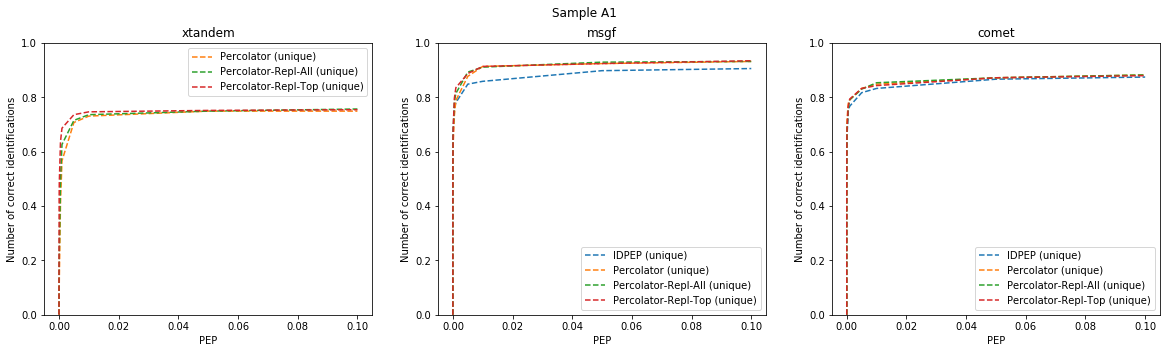

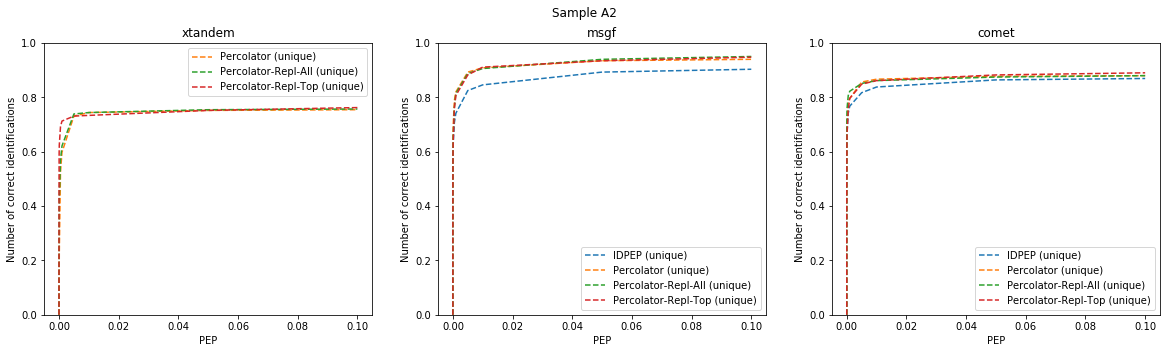

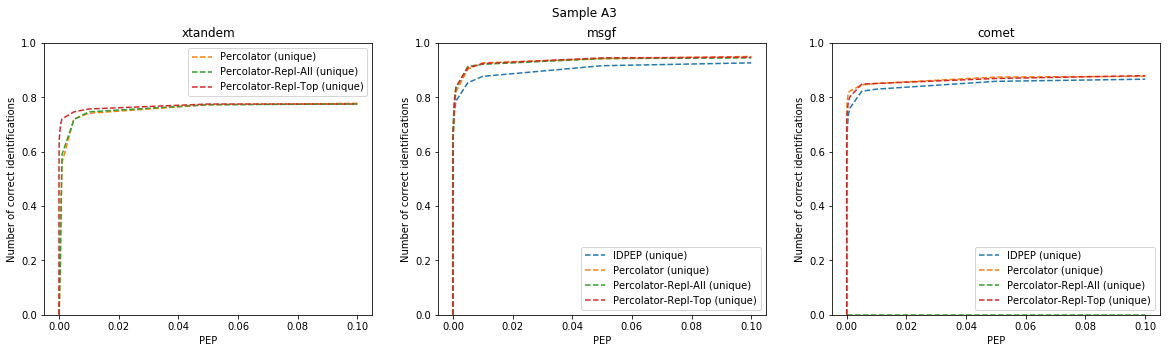

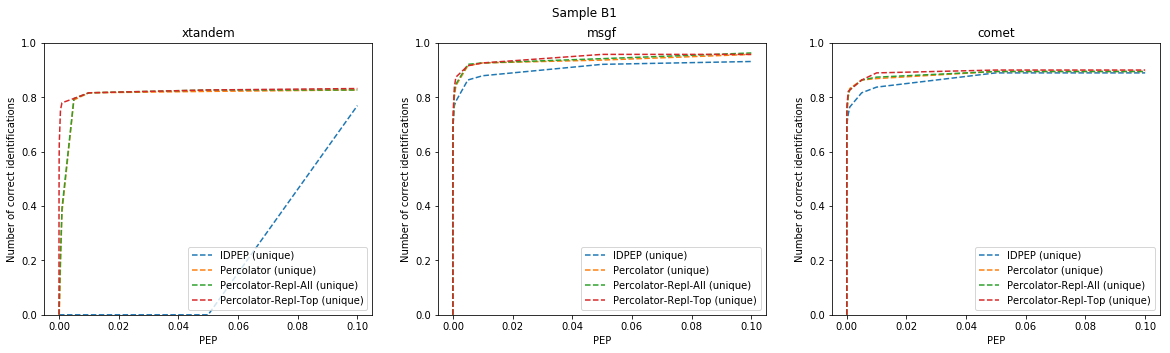

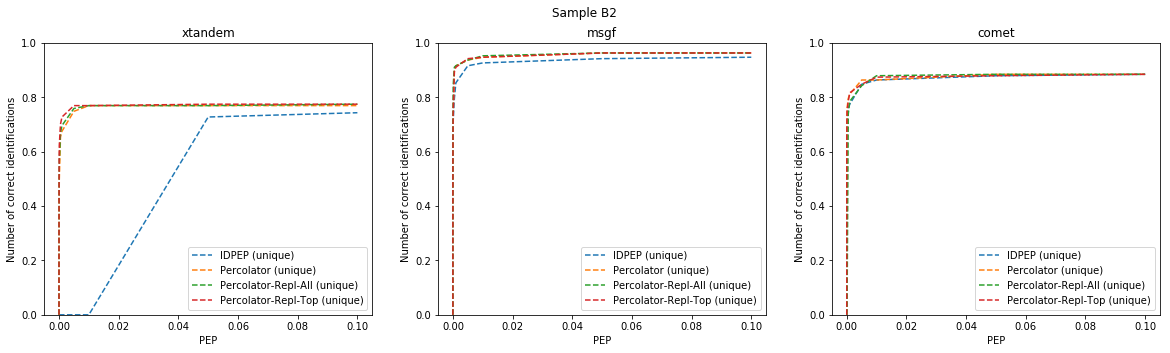

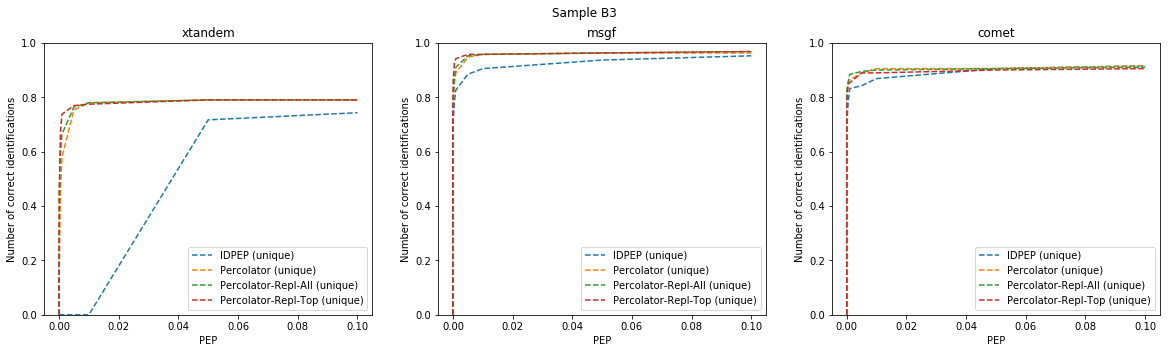

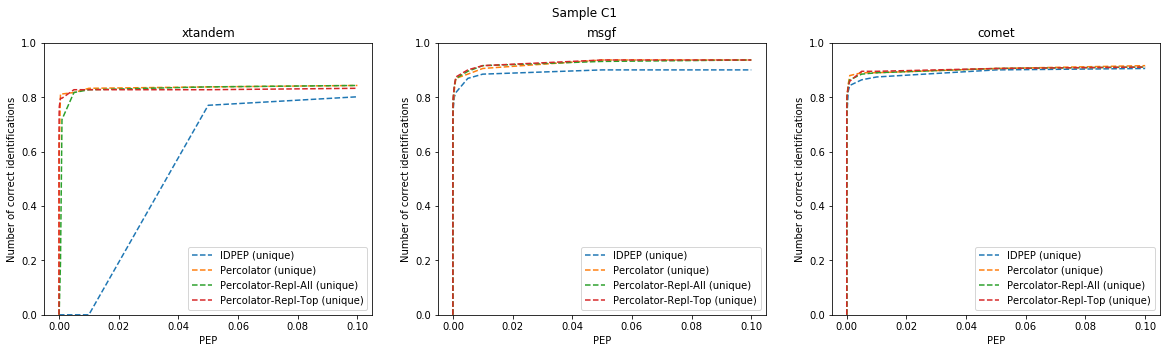

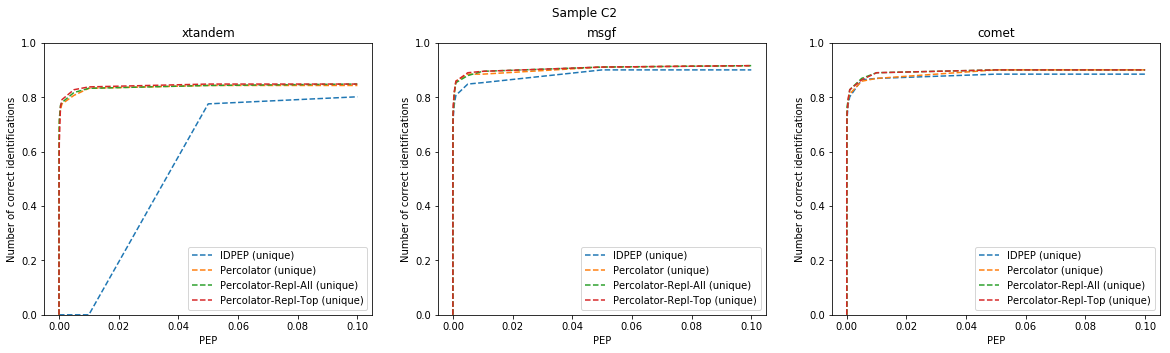

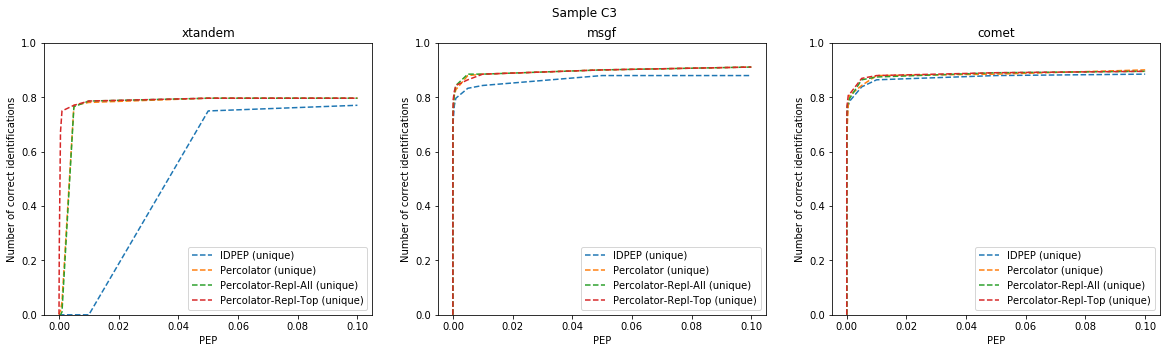

In [119]:
plot_correct_identifications(absolute=False)

# ROC curves

In [120]:
for sample in list("ABCD"):
    for rep in [1, 2, 3]:
        for engine in ["xtandem", "msgf", "comet"]:
            for method in ["IDPEP", "Percolator", "Percolator-Repl-All", "Percolator-Repl-Top"]:
                key = (sample, rep, engine, method)
                if key in data:
                    d = data[key]
                    for psm in d:
                        psm["correct"] = is_correct(psm, sample)

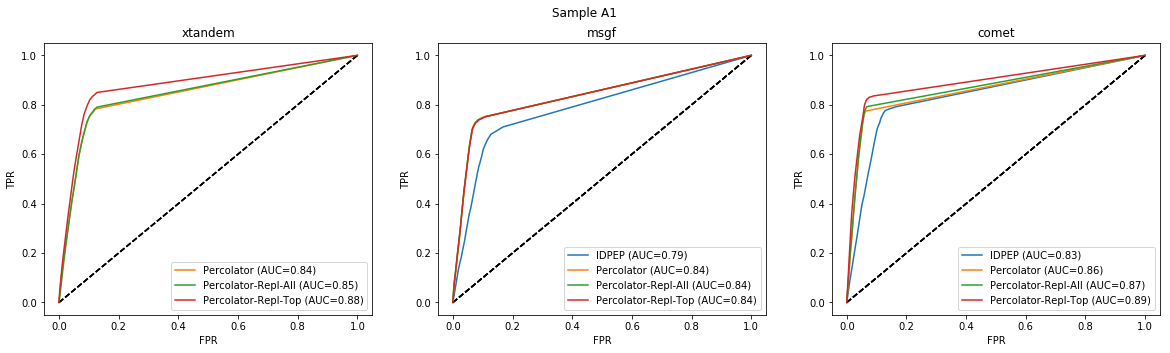

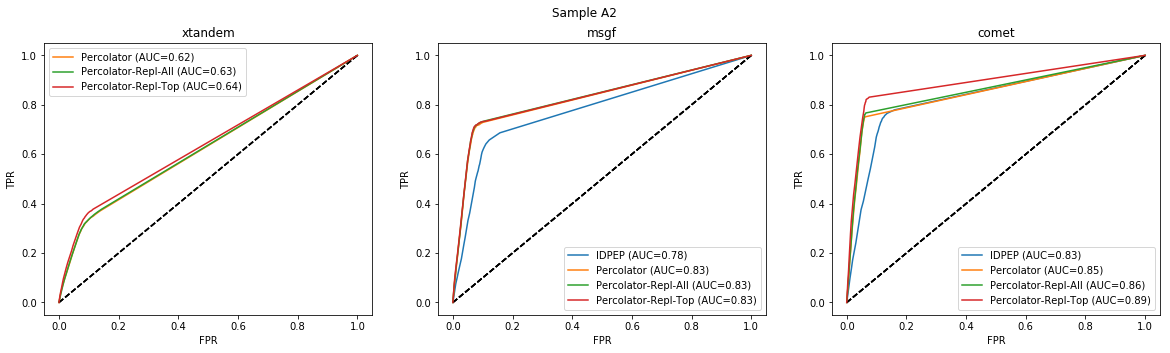

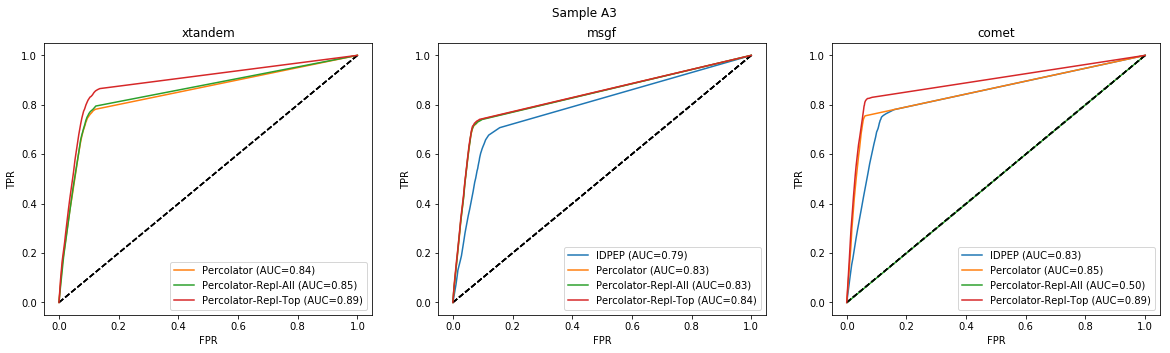

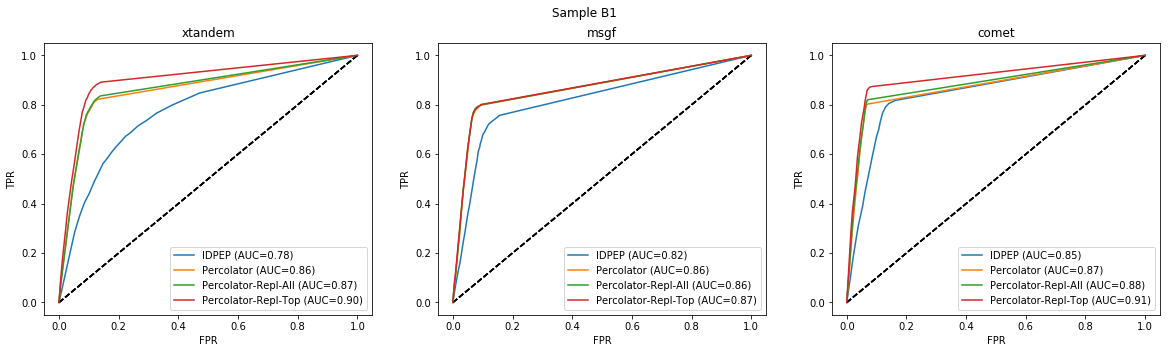

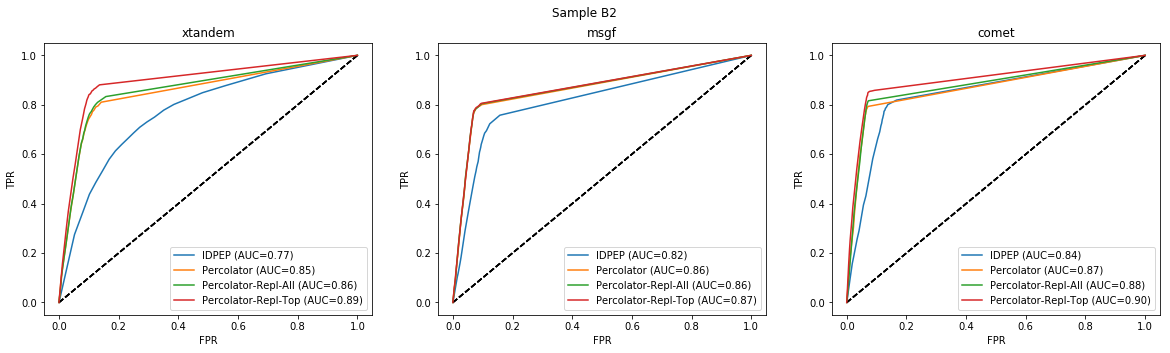

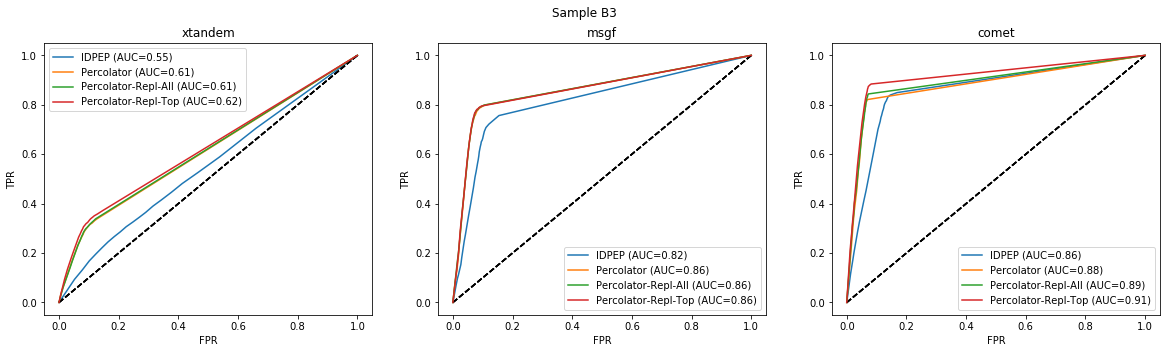

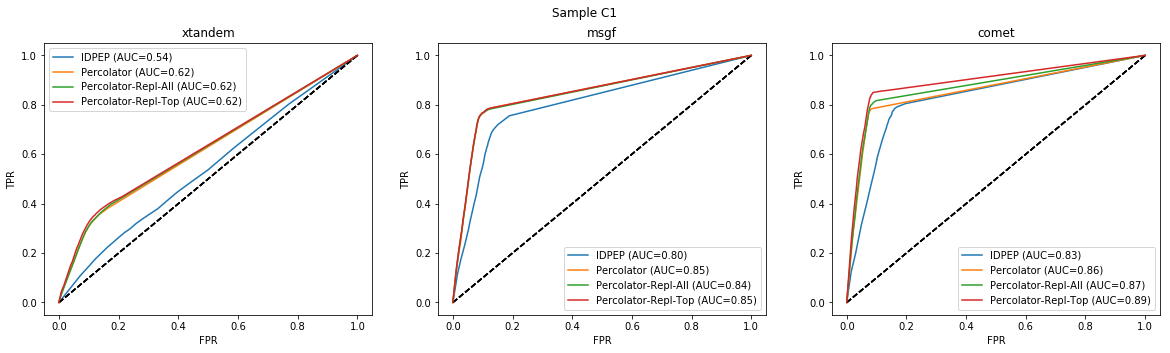

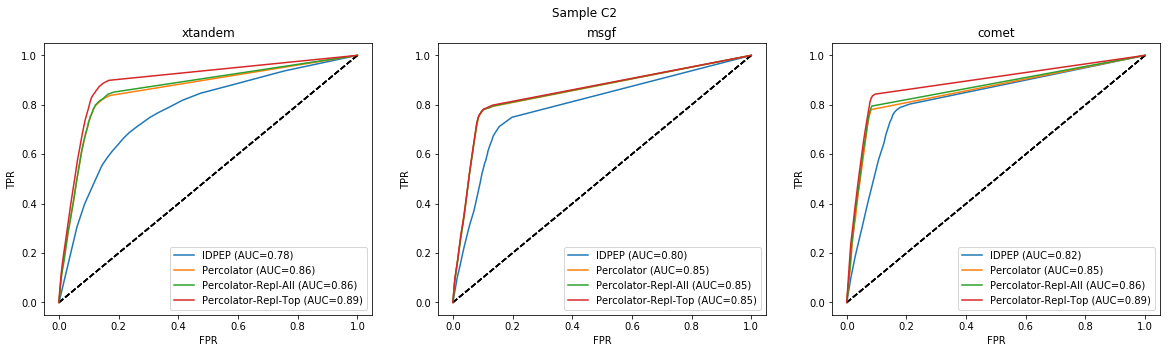

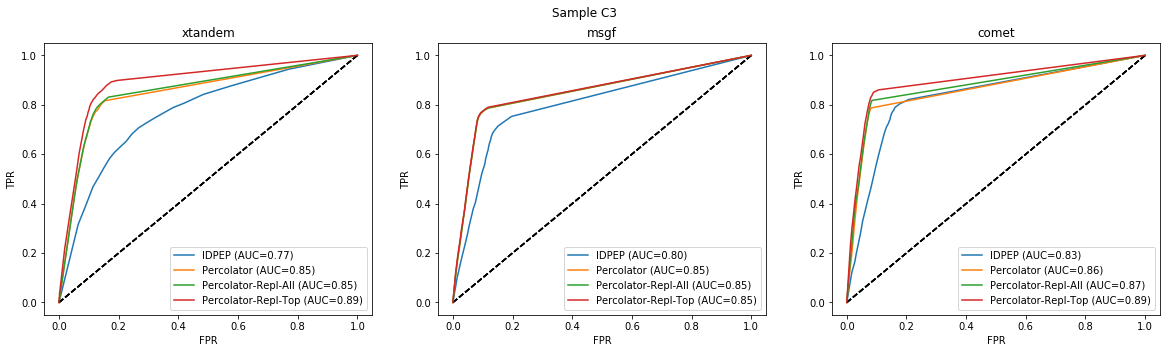

In [121]:
for sample in list("ABC"):
    for rep in [1, 2, 3]:
        fig, axarr = plt.subplots(1, 3, figsize=(20, 5))
        for i, engine in enumerate(["xtandem", "msgf", "comet"]):
            for j, method in enumerate(["IDPEP", "Percolator", "Percolator-Repl-All", "Percolator-Repl-Top"]):
                key = (sample, rep, engine, method)
                if key in data:
                    d = data[key]
                    d = [psm for psm in d if "PEP" in psm]
                    thresh_list, tp_rates, fp_rates = analyse.roc_curve(d)
                    auc_val = auc(fp_rates, tp_rates)
                    axarr[i].plot([0, 1], [0, 1], ls="--", color="k")
                    axarr[i].plot(fp_rates, tp_rates, label="{} (AUC={:.2f})".format(method, auc_val), color="C{}".format(j))
                    axarr[i].set_xlabel("FPR")
                    axarr[i].set_ylabel("TPR")
                    axarr[i].legend()
                    axarr[i].set_title(engine)
                    axarr[i].set_xlim(0 - 0.05, 1 + 0.05)
                    axarr[i].set_ylim(0 - 0.05, 1 + 0.05)
        plt.suptitle("Sample {}{}".format(sample, rep));
        plt.show(fig)
        plt.close(fig)

# Precision-Recall Curves

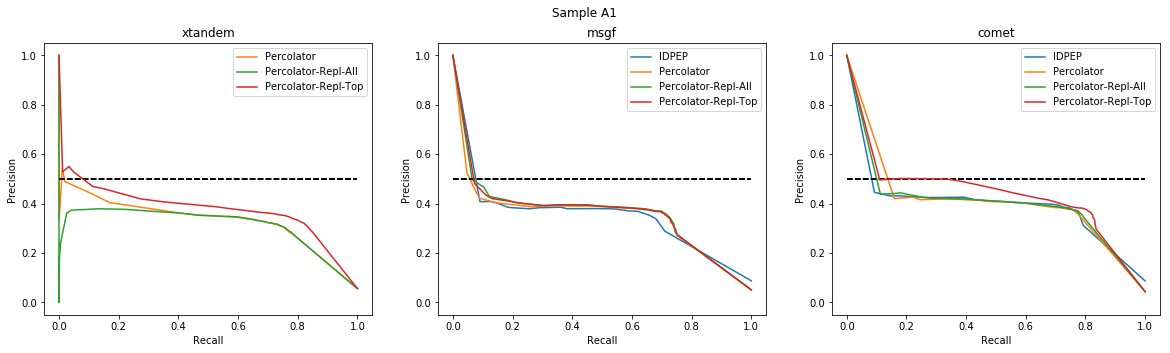

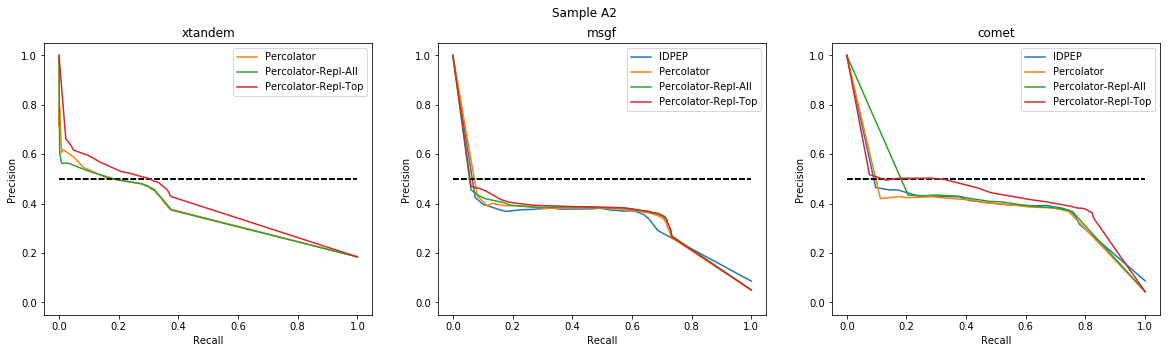

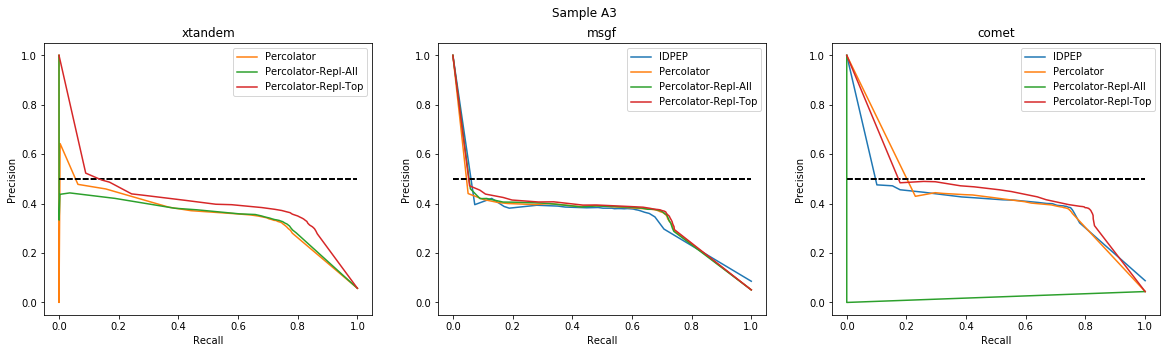

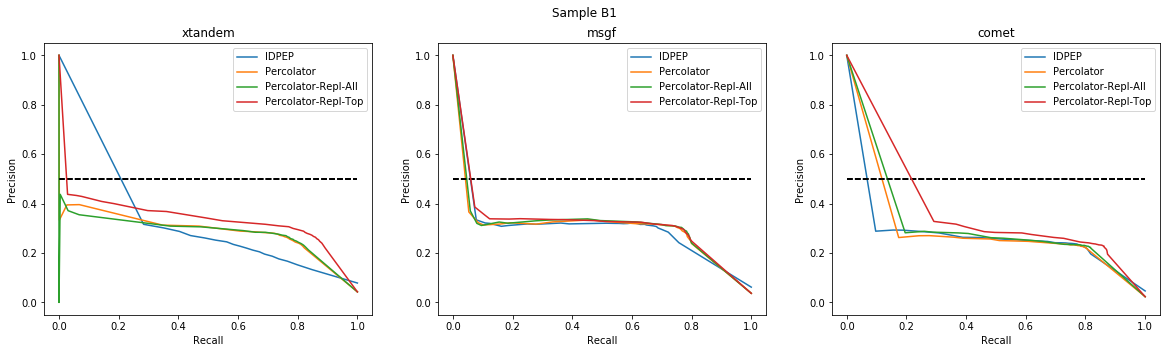

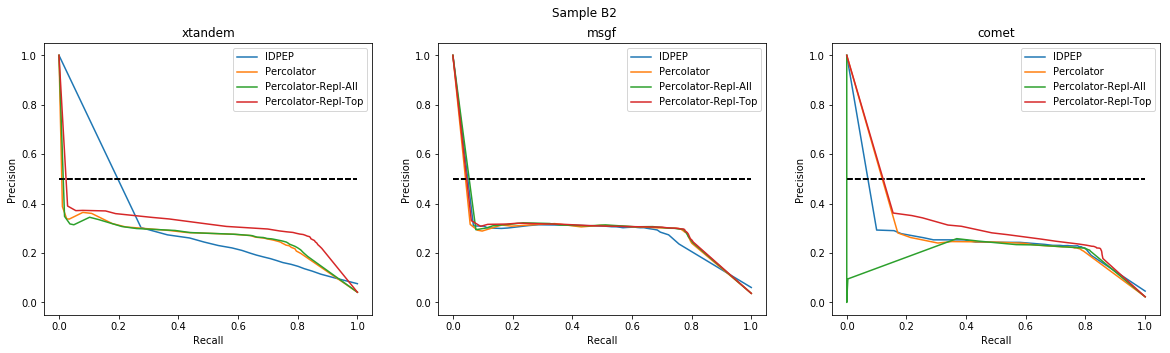

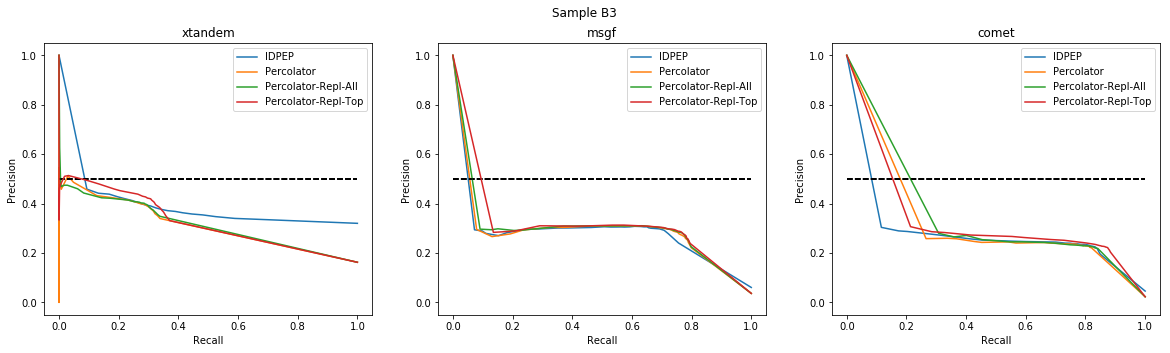

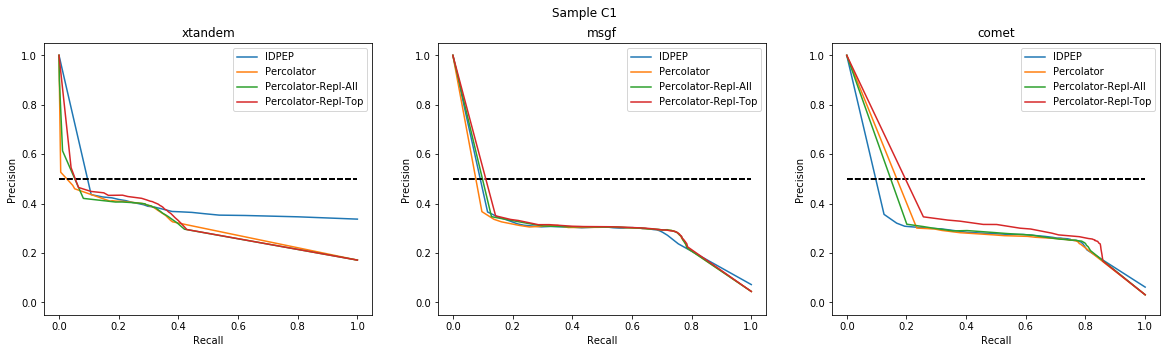

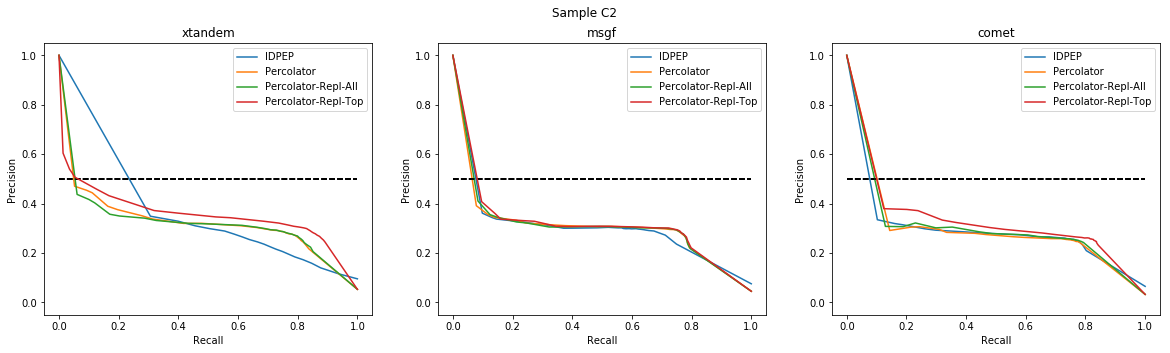

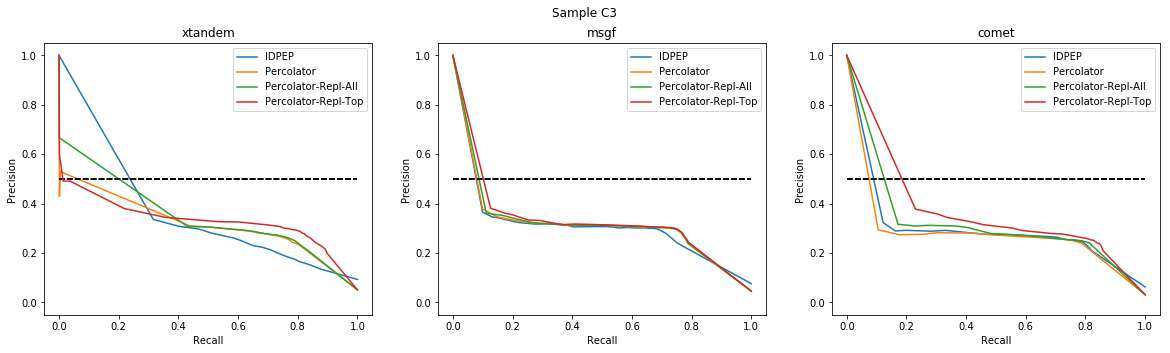

In [122]:
for sample in list("ABC"):
    for rep in [1, 2, 3]:
        fig, axarr = plt.subplots(1, 3, figsize=(20, 5))
        for i, engine in enumerate(["xtandem", "msgf", "comet"]):
            for j, method in enumerate(["IDPEP", "Percolator", "Percolator-Repl-All", "Percolator-Repl-Top"]):
                key = (sample, rep, engine, method)
                if key in data:
                    d = data[key]
                    d = [psm for psm in d if "PEP" in psm]
                    thresh_list, precision, recall = analyse.precision_recall_curve(d)
                    axarr[i].plot([0, 1], [0.5, 0.5], ls="--", color="k")
                    axarr[i].plot(recall, precision, label=method, color="C{}".format(j))
                    axarr[i].set_xlabel("Recall")
                    axarr[i].set_ylabel("Precision")
                    axarr[i].legend()
                    axarr[i].set_title(engine)
                    axarr[i].set_xlim(0 - 0.05, 1 + 0.05)
                    axarr[i].set_ylim(0 - 0.05, 1 + 0.05)
        plt.suptitle("Sample {}{}".format(sample, rep));
        plt.show(fig)
        plt.close(fig)

# Actual vs computed PEP

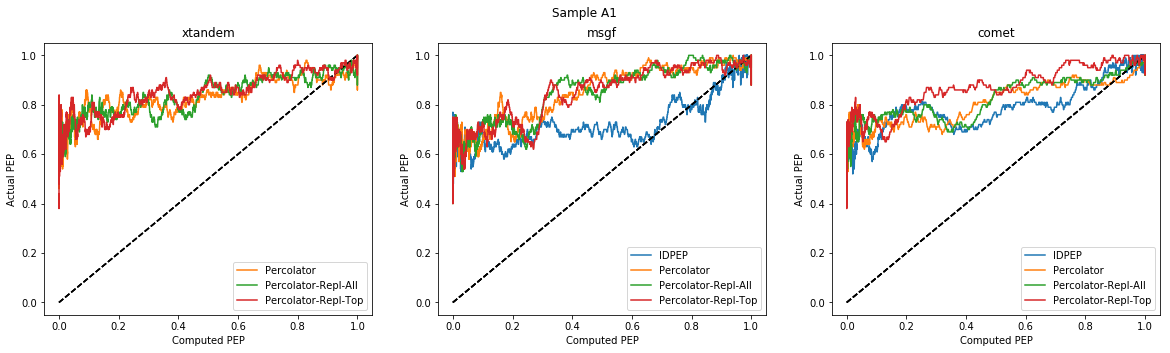

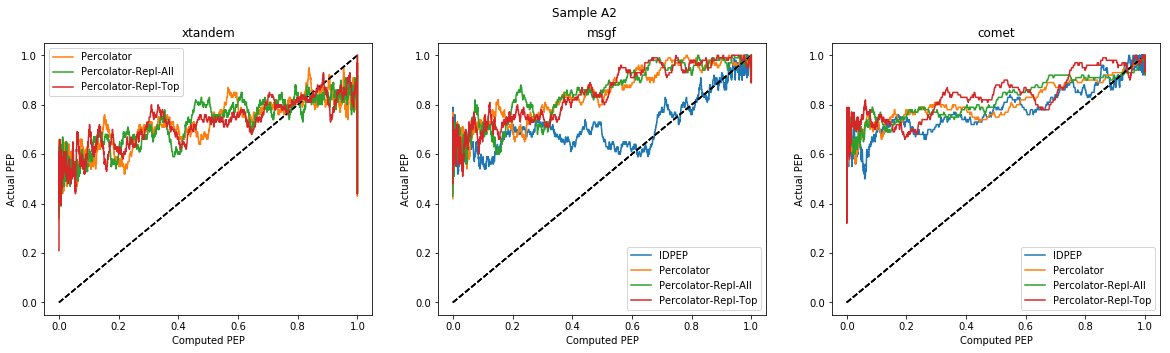

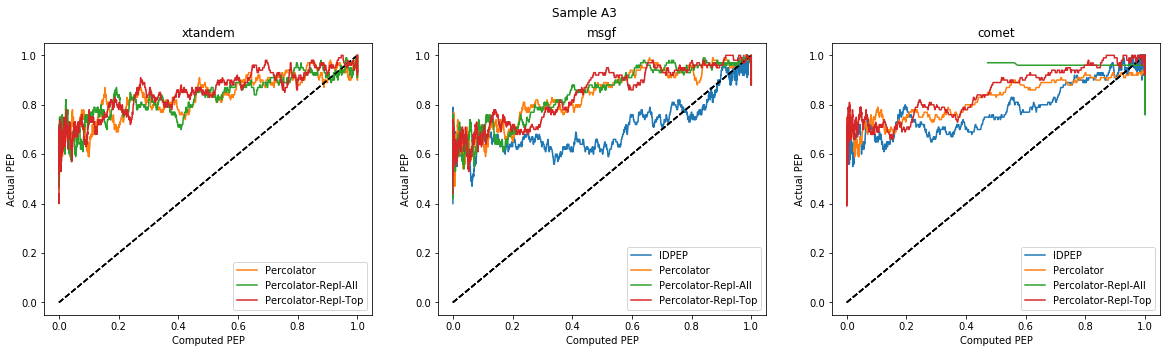

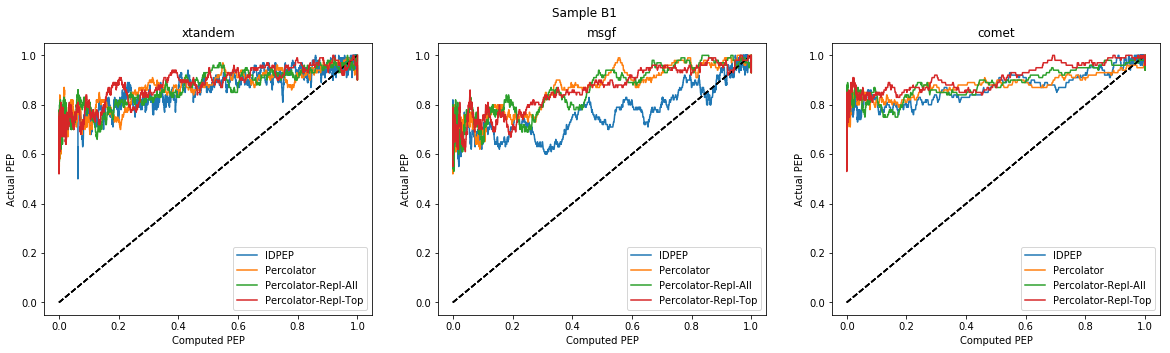

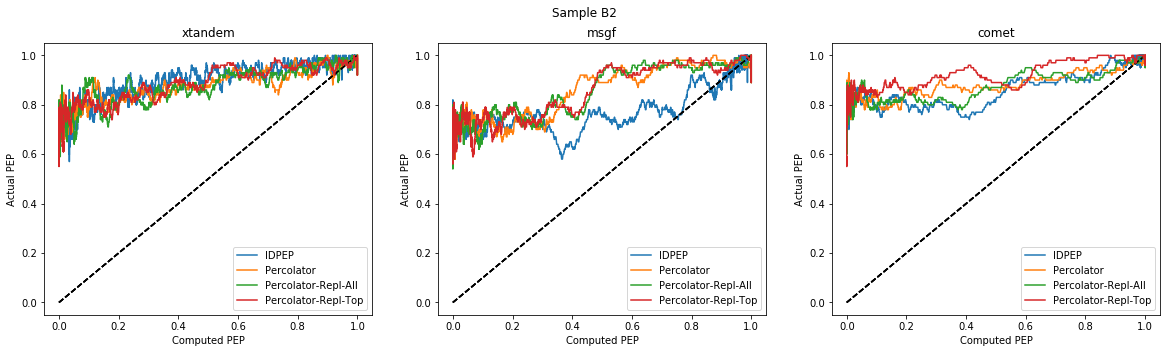

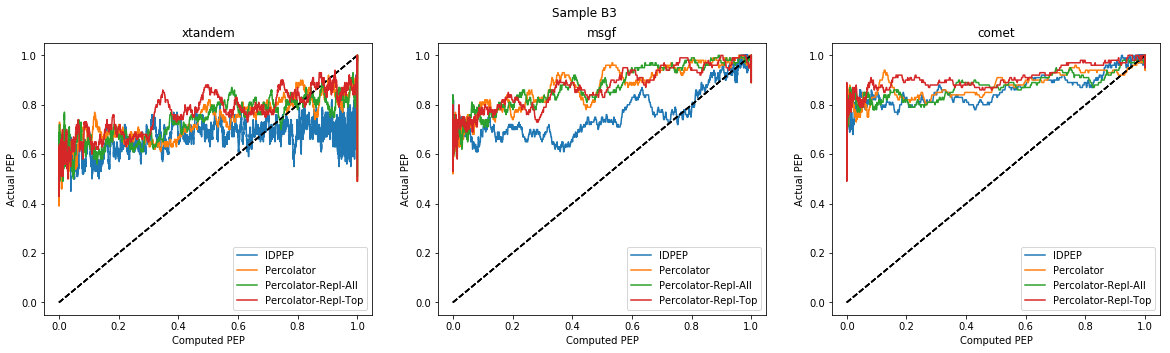

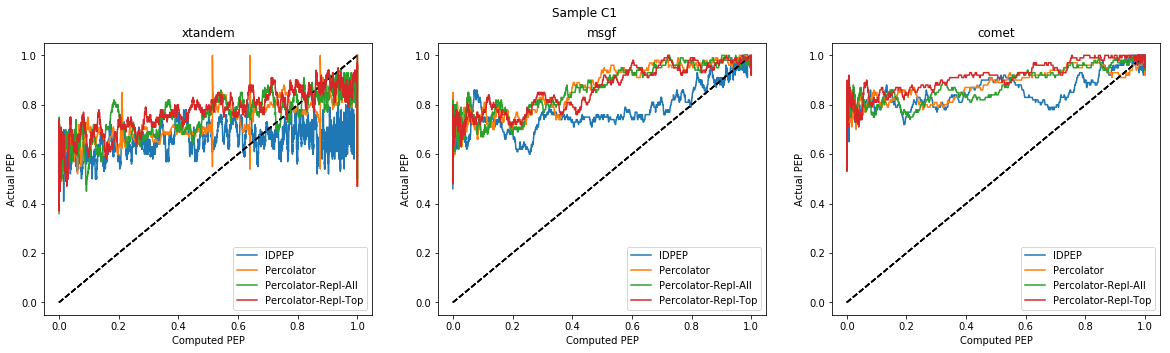

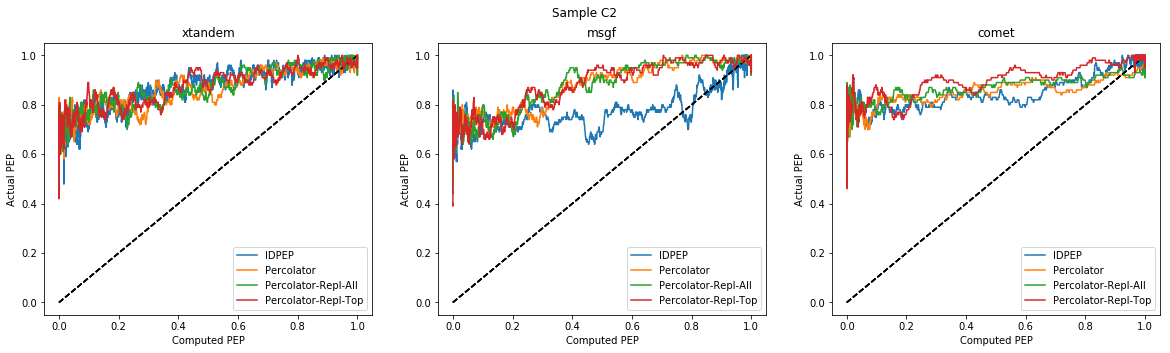

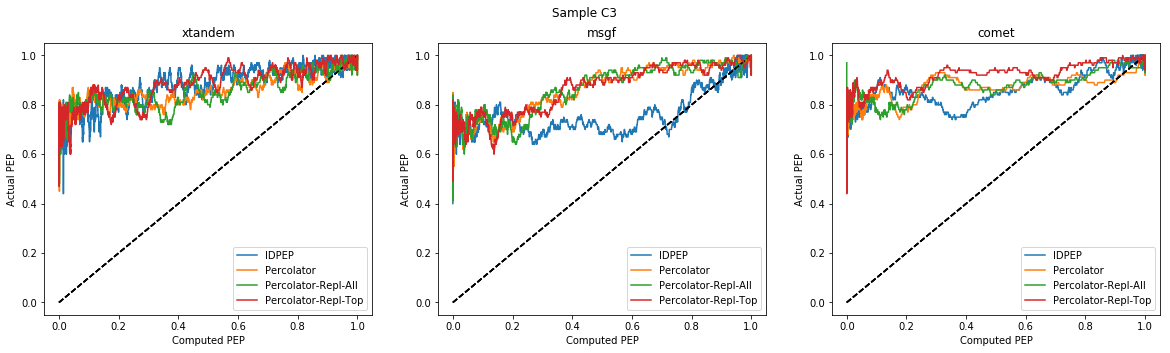

In [123]:
for sample in list("ABC"):
    for rep in [1, 2, 3]:
        fig, axarr = plt.subplots(1, 3, figsize=(20, 5))
        for i, engine in enumerate(["xtandem", "msgf", "comet"]):
            for j, method in enumerate(["IDPEP", "Percolator", "Percolator-Repl-All", "Percolator-Repl-Top"]):
                key = (sample, rep, engine, method)
                if key in data:
                    d = data[key]
                    d = [psm for psm in d if "PEP" in psm]
                    actual, computed = analyse.actual_vs_computed_pep(d)
                    axarr[i].plot([0, 1], [0, 1], ls="--", color="k")
                    axarr[i].plot(computed, actual, label=method, color="C{}".format(j))
                    axarr[i].set_xlabel("Computed PEP")
                    axarr[i].set_ylabel("Actual PEP")
                    axarr[i].legend()
                    axarr[i].set_title(engine)
                    axarr[i].set_xlim(0 - 0.05, 1 + 0.05)
                    axarr[i].set_ylim(0 - 0.05, 1 + 0.05)
        plt.suptitle("Sample {}{}".format(sample, rep));
        plt.show(fig)
        plt.close(fig)